# Imports and Constraints

# Defines

In [460]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import category_encoders as ce
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator


def load_data() -> pd.Series:
    csv_train = pd.read_csv('train.txt', sep=" ").assign(train = 1) 
    csv_test = pd.read_csv('testx.txt', sep=" ").assign(train = 0)
    csv = pd.concat([csv_train,csv_test])
    classes = csv['class']
    csv = csv.drop(['class'], axis=1)
#     print(f"class0: {percentage0}%,\tclass1: {percentage1}%")
    return csv, classes

def del_nans(nans_perc):
    # Find those where nans is over nans_perc
    global csv, nans
    na = csv.isna().sum()
    del_na = na[na >= nans_perc*len(csv)]
    csv = csv.drop(del_na.index.values, axis=1)
    nans = nans_ctr()
    
def nans_ctr() -> pd.Series:
    return csv.isna().sum()

def unique_ctr() -> pd.Series():
    unique = pd.Series()
    for col in list(csv_org):
    #     len(csv[col].unique().astype(int))
    #     print(f"col {col}\t unique: {len(csv[col].unique())}")
        if(csv.columns.contains(col) and (col != 'train')):
            unique.at[col] = len(csv[col].unique())
#     print(unique.head(5))
    return unique
def val_types() -> pd.Series():
    val_type = pd.Series()
    for col in list(csv_org):
        if not csv.columns.contains(col) or col == 'train':
            continue
        if csv[col].dtype == np.float64:
            val_type.at[col] = np.float64
        elif csv[col].dtype == np.int64:
            val_type.at[col] = np.int64
        elif csv[col].dtype == np.int32:
            val_type.at[col] = np.int32
        elif csv[col].dtype == object:
            val_type.at[col] = object
        else:
            print(f"No common value type found in val_types() - {csv[col].dtype}")
#     print(f"float: {sum(val_type == np.float64)}")
#     print(f"int: {sum(val_type == np.int64)}")
#     print(f"string: {sum(val_type == object)}")
    return val_type
def stat(f):
    nans = nans_ctr()
    unique = unique_ctr()
    val_type = val_types()
    print(f"min: {csv[f].min()}")
    print(f"max: {csv[f].max()}")
    print(f"nans: {nans[f]}")
    print(f"unique: {unique[f]}")
    print(f"val_type: {val_type[f]}")
    print(f"vals per class: {round((len(csv)-nans[f])/unique[f],2)}")
    
def plot(data, sort=False, log=True, small=False, fontsize=7):
    if small:
        figsize = (8,4)
    else:
        figsize = (20,10)
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    if sort:
        ax = df.sort_values(by=0, ascending=False).plot(grid=True,kind='bar', logy = log, figsize=figsize, legend=False)
    else:
        ax = df.plot(grid=True,kind='bar', logy = log, figsize=figsize, legend=False)
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.show()
    
def threshold_factorization(data, *t_list) -> pd.Series():
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df = df.sort_values(by=0, ascending=False)
    t_list = (df.values[0].item()+1,) + t_list + (0,)
    out = data.copy()
#     print(f"all labels: {len(letter_counts)}")
    for i in tqdm(range(1,len(t_list)),desc="Progress",leave=False):
        idx = df[(df>t_list[i]).values & (df<=t_list[i-1]).values].index
#         print(f"labels in range ({t_list[i]}, {t_list[i-1]}): {len(idx)}")
        for j in tqdm(idx,leave=False):
            out.loc[out == j] = i
    return out

def factorize(data) -> pd.Series():
#     series = data.fillna(-1)
    series = data.copy()
    labels, _ = pd.factorize(series)
    series = labels[:len(series)]
    return series

def cast(data, lower_t, upper_t) -> pd.Series():
#     print(f"Casting with max , min = ({lower_t},{upper_t})")
    data = data.sort_values()
    data[data<lower_t] = lower_t
    data[data>upper_t] = upper_t
    return data

def standarize(df) ->pd.Series():
    return round((df-df.min())/(df.max()-df.min()),4)

def one_hot_encoding(f):
    global csv
    ohe = ce.OneHotEncoder(cols = [f], handle_unknown='ignore', use_cat_names=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)
    
def binary_encoding(f):
    global csv
    ohe = ce.BinaryEncoder(cols = [f], handle_unknown='ignore',drop_invariant=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)  
def delete(f):
    global csv
    csv[f] = csv_org[f]
    csv = csv.drop(f, axis=1)

# Template

In [25]:
f = 'Var'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
stat(f)
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000,100,1)
# csv[f] = standarize(csv[f])
# csv[f] = factorize(csv[f])
plot(csv[f].sort_values(),small=True)
# one_hot_encoding(f)

KeyError: 'Var'

# Data Cleaning

In [21]:
csv,classes = load_data()
csv_org = csv.copy()
nans = nans_ctr()
unique = unique_ctr()
val_type = val_types()
print(max(nans))
del_nans(0.99)
print(max(nans))
print(len(csv.columns))

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


50000
49442
207


# Data Preprocessing

In [823]:
for col in csv.columns:
    print(col,end="")
    print(f" min: {csv[col].min()}\tmax: {csv[col].max()}")

Var1 min: 0.0	max: 1.0
Var10 min: 0.0	max: 1.0
Var100 min: 0.0	max: 1.0
Var101 min: 1.0	max: 2.0
Var103 min: 0.0	max: 1.0
Var104 min: 0.0	max: 1.0
Var107 min: 0.0	max: 1.0
Var109 min: 0.0	max: 1.0
Var11 min: 0.0	max: 1.0
Var110 min: 0.0	max: 1.0
Var111 min: 0.0	max: 1.0
Var112 min: 0.0	max: 1.0
Var114 min: 0.0	max: 1.0
Var115 min: 0.0	max: 1.0
Var117 min: 0.0	max: 1.0
Var119 min: 0.0	max: 1.0
Var12 min: 0.0	max: 1.0
Var120 min: 0.0	max: 1.0
Var121 min: 0.0	max: 1.0
Var123 min: 0.0	max: 1.0
Var124 min: 0.0	max: 1.0
Var125 min: 0.0	max: 1.0
Var126 min: 0.0	max: 1.0
Var127 min: 0.0	max: 1.0
Var128 min: 0.0	max: 1.0
Var129 min: 0.0	max: 1.0
Var13 min: 0.0	max: 1.0
Var131 min: 0.0	max: 1.0
Var132 min: 0.0	max: 1.0
Var133 min: 0.0	max: 1.0
Var134 min: 0.0	max: 5735340.0
Var135 min: 0.0	max: 1.0
Var137 min: 0.0	max: 1.0
Var139 min: 0.0	max: 1.0
Var144 min: 0.0	max: 1.0
Var145 min: 0.0	max: 1.0
Var147 min: 0.0	max: 1.0
Var148 min: 0.0	max: 1.0
Var149 min: 0.0	max: 1.0
Var150 min: 0.0	max: 1.0


Var36_2210.0 min: 0	max: 1
Var36_762506.0 min: 0	max: 1
Var36_318792.0 min: 0	max: 1
Var36_104092.0 min: 0	max: 1
Var36_64134.0 min: 0	max: 1
Var36_1125710.0 min: 0	max: 1
Var36_67568.0 min: 0	max: 1
Var36_111494.0 min: 0	max: 1
Var36_63332.0 min: 0	max: 1
Var36_3746.0 min: 0	max: 1
Var36_168724.0 min: 0	max: 1
Var36_257694.0 min: 0	max: 1
Var36_88276.0 min: 0	max: 1
Var36_1166932.0 min: 0	max: 1
Var36_496780.0 min: 0	max: 1
Var36_250038.0 min: 0	max: 1
Var36_24312.0 min: 0	max: 1
Var36_1043040.0 min: 0	max: 1
Var36_18456.0 min: 0	max: 1
Var36_976874.0 min: 0	max: 1
Var36_42062.0 min: 0	max: 1
Var36_167906.0 min: 0	max: 1
Var36_72000.0 min: 0	max: 1
Var36_77854.0 min: 0	max: 1
Var36_357170.0 min: 0	max: 1
Var36_29744.0 min: 0	max: 1
Var36_249058.0 min: 0	max: 1
Var36_342538.0 min: 0	max: 1
Var36_52734.0 min: 0	max: 1
Var36_413318.0 min: 0	max: 1
Var36_351014.0 min: 0	max: 1
Var36_447646.0 min: 0	max: 1
Var36_1494634.0 min: 0	max: 1
Var36_92316.0 min: 0	max: 1
Var36_211580.0 min: 0	max:

Var36_10560.0 min: 0	max: 1
Var36_1953786.0 min: 0	max: 1
Var36_580052.0 min: 0	max: 1
Var36_1302910.0 min: 0	max: 1
Var36_78810.0 min: 0	max: 1
Var36_268764.0 min: 0	max: 1
Var36_1986.0 min: 0	max: 1
Var36_24074.0 min: 0	max: 1
Var36_109580.0 min: 0	max: 1
Var36_715432.0 min: 0	max: 1
Var36_525952.0 min: 0	max: 1
Var36_304022.0 min: 0	max: 1
Var36_605306.0 min: 0	max: 1
Var36_82678.0 min: 0	max: 1
Var36_16244.0 min: 0	max: 1
Var36_44898.0 min: 0	max: 1
Var36_436942.0 min: 0	max: 1
Var36_169694.0 min: 0	max: 1
Var36_1206624.0 min: 0	max: 1
Var36_1177400.0 min: 0	max: 1
Var36_172790.0 min: 0	max: 1
Var36_250996.0 min: 0	max: 1
Var36_12616.0 min: 0	max: 1
Var36_829512.0 min: 0	max: 1
Var36_31500.0 min: 0	max: 1
Var36_173710.0 min: 0	max: 1
Var36_38612.0 min: 0	max: 1
Var36_1270.0 min: 0	max: 1
Var36_2844.0 min: 0	max: 1
Var36_341382.0 min: 0	max: 1
Var36_39310.0 min: 0	max: 1
Var36_132762.0 min: 0	max: 1
Var36_256748.0 min: 0	max: 1
Var36_22966.0 min: 0	max: 1
Var36_59596.0 min: 0	max: 1

In [505]:
csv.to_csv("after_processing.csv", sep=',')

In [578]:
f = 'Var230'
delete(f)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


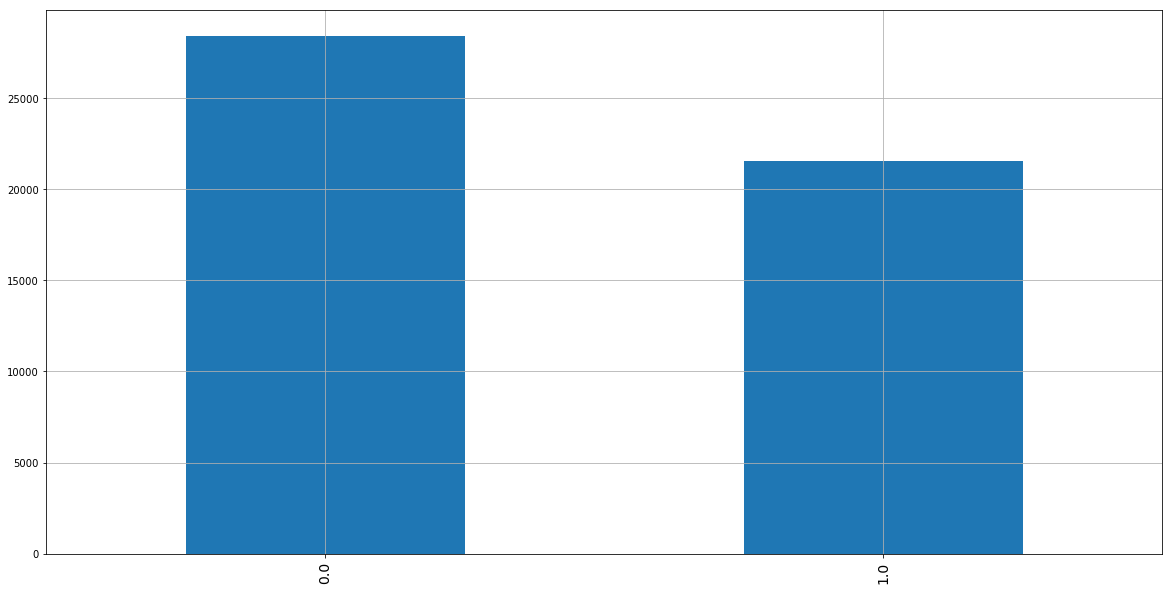

In [579]:
f = 'Var229'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


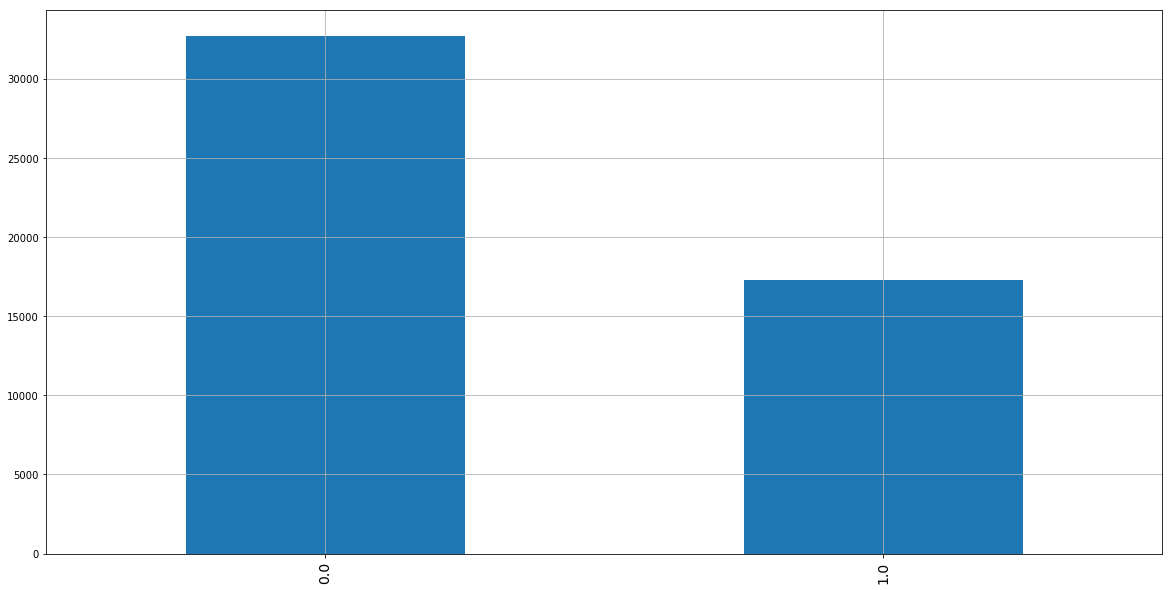

In [580]:
f = 'Var228'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=1]) = 2
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


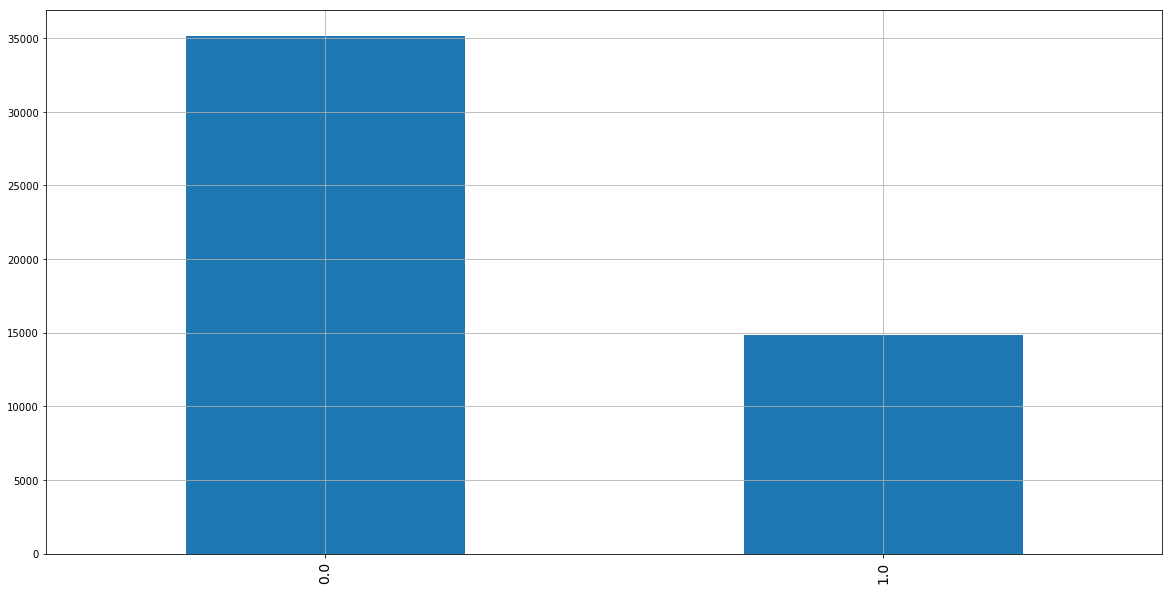

In [581]:
f = 'Var227'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=1]) = 2
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


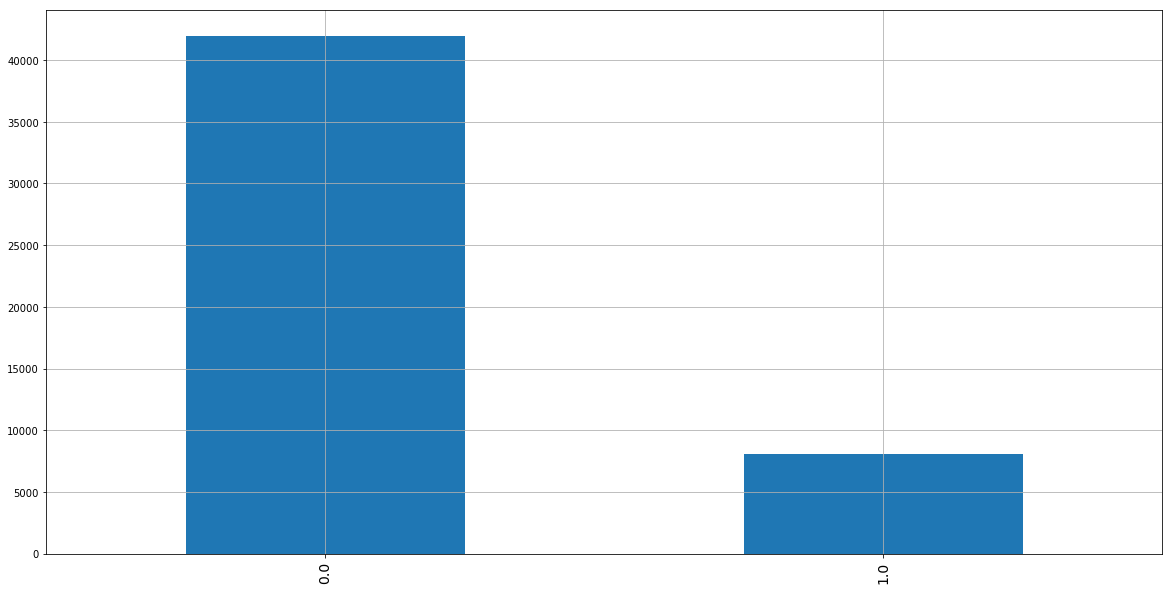

In [582]:
f = 'Var226'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=5]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


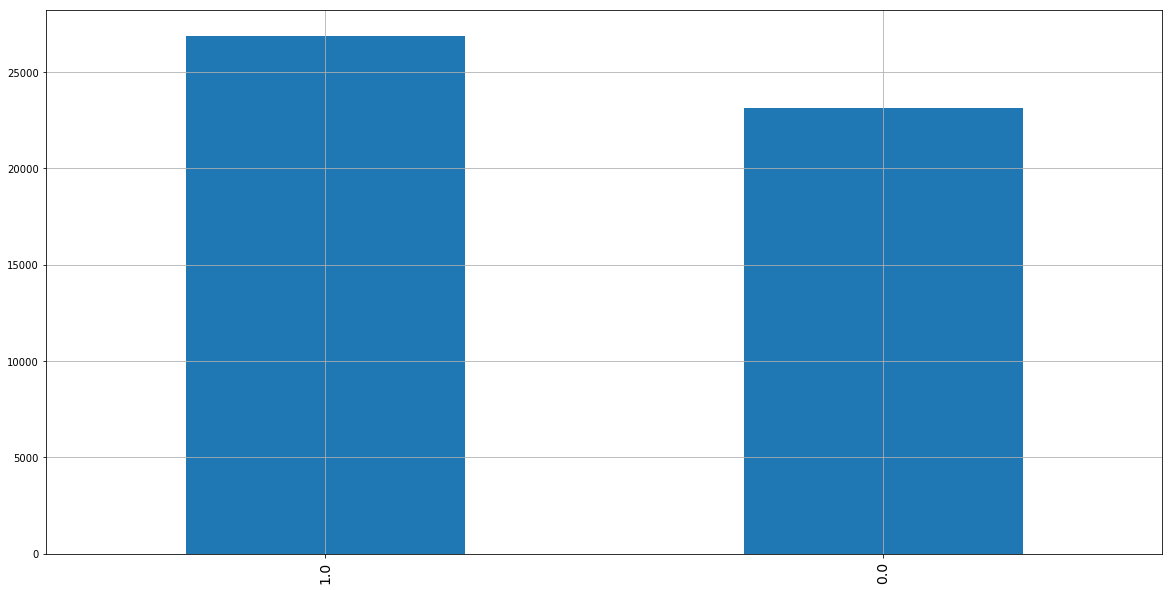

In [583]:
f = 'Var225'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]==2]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

In [821]:
f = 'Var224'
delete(f)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


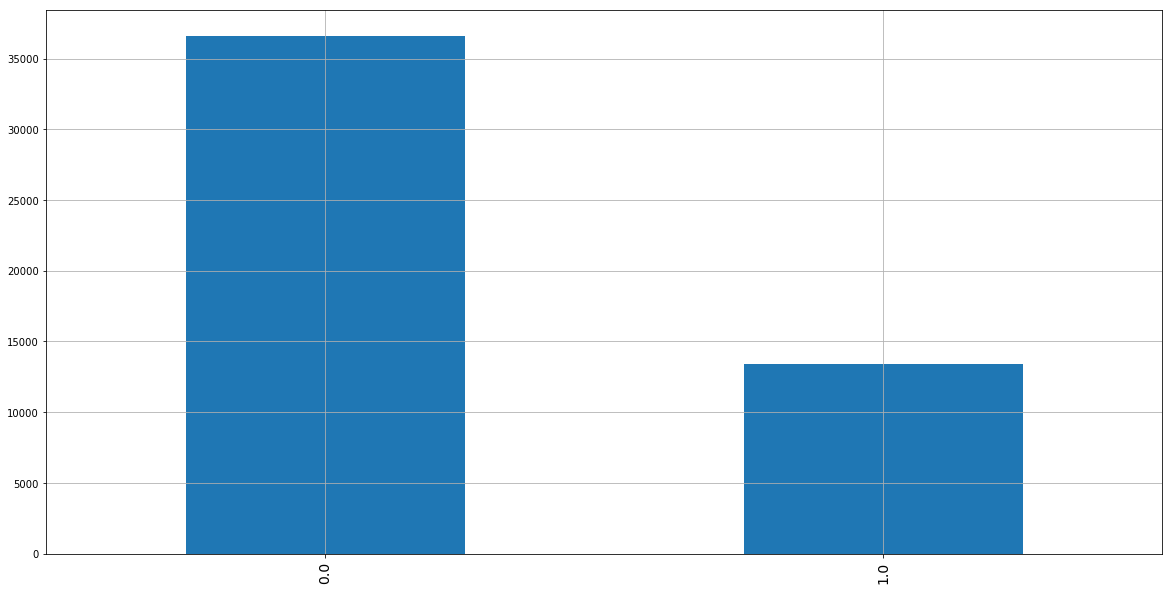

In [584]:
f = 'Var223'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

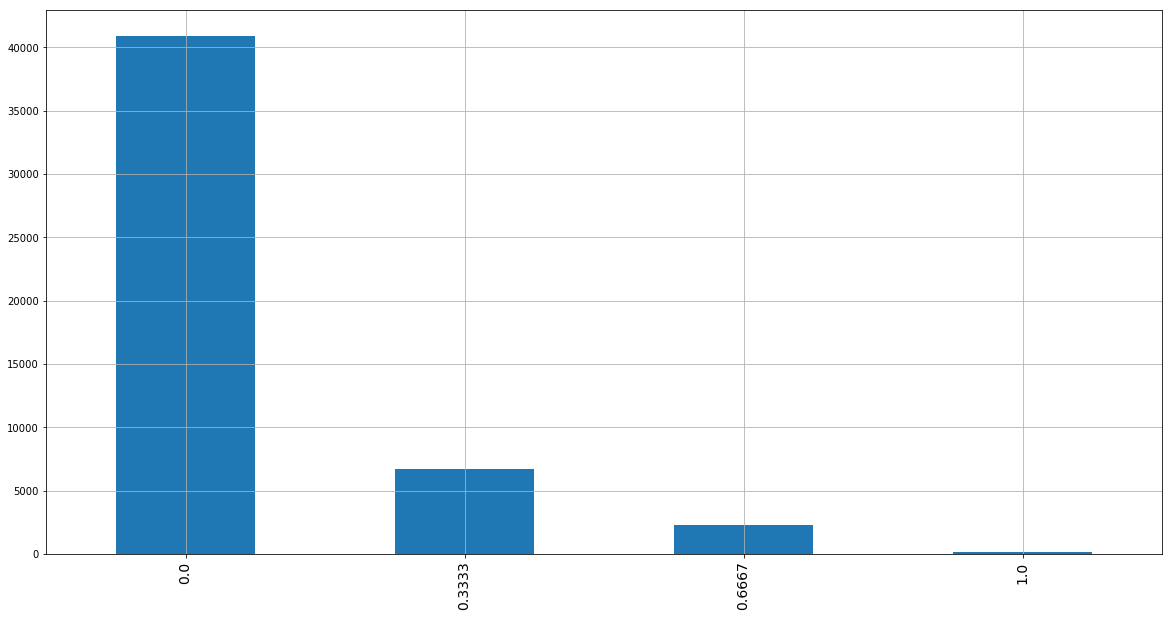

In [585]:
f = 'Var223'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
# (csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

In [586]:
f = 'Var222'
delete(f)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


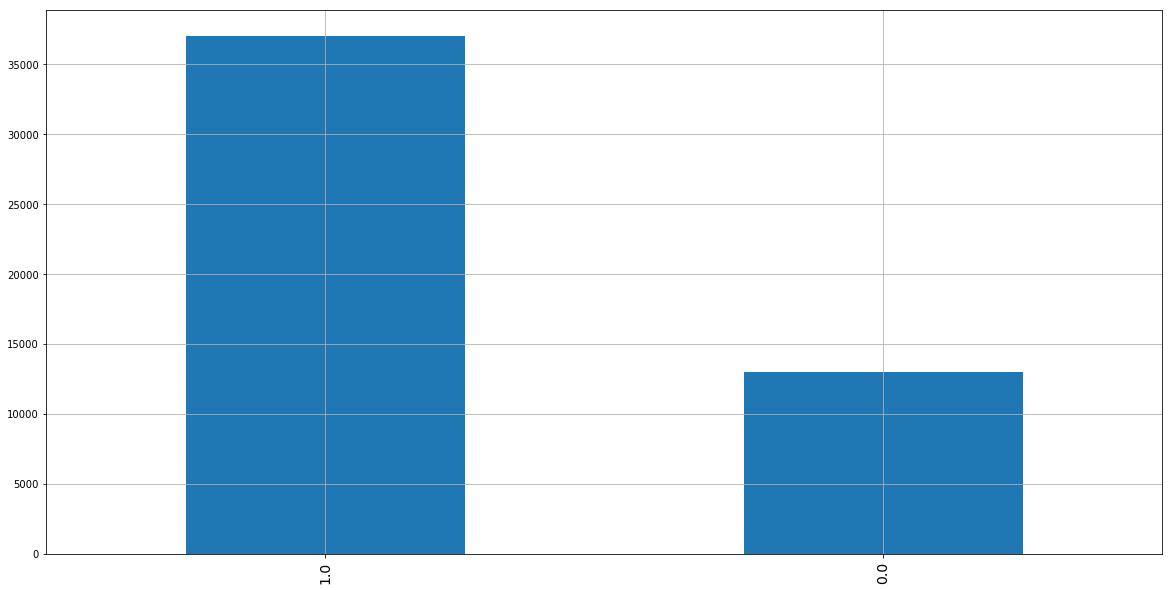

In [587]:
f = 'Var221'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=1]) = 0
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

In [588]:
f = 'Var220'
delete(f)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


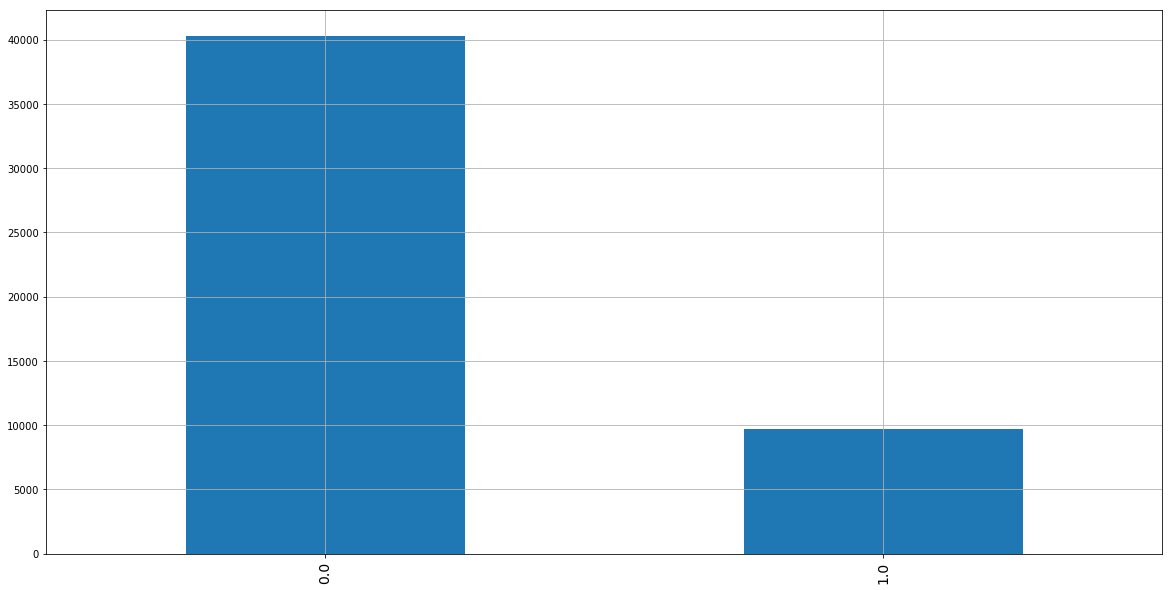

In [589]:
f = 'Var219'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


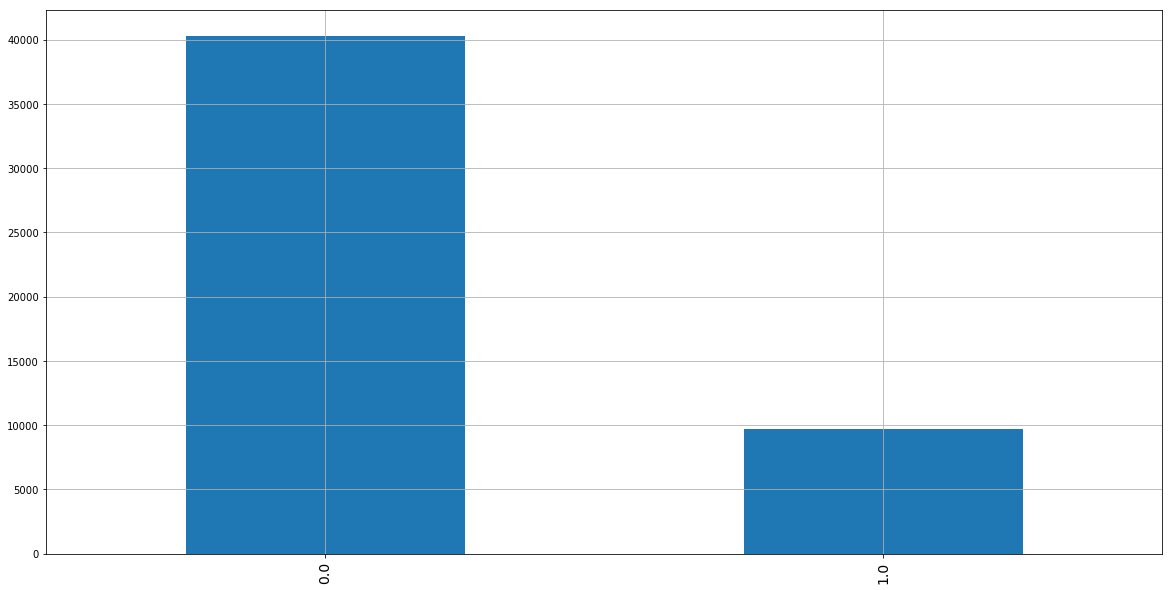

In [590]:
f = 'Var219'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

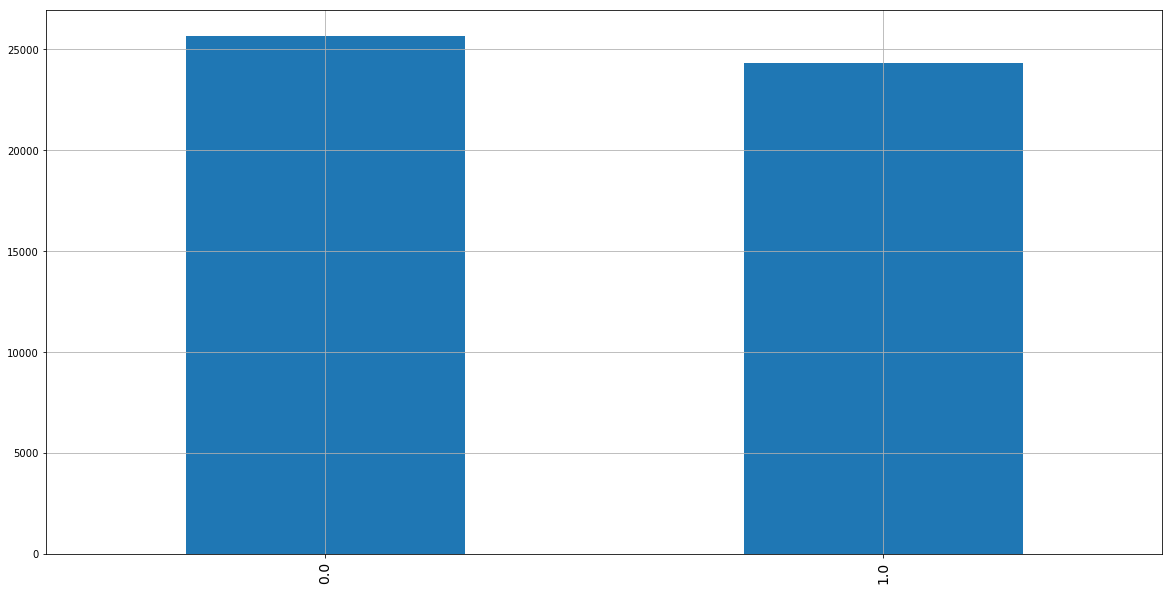

In [591]:
f = 'Var218'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
# (csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

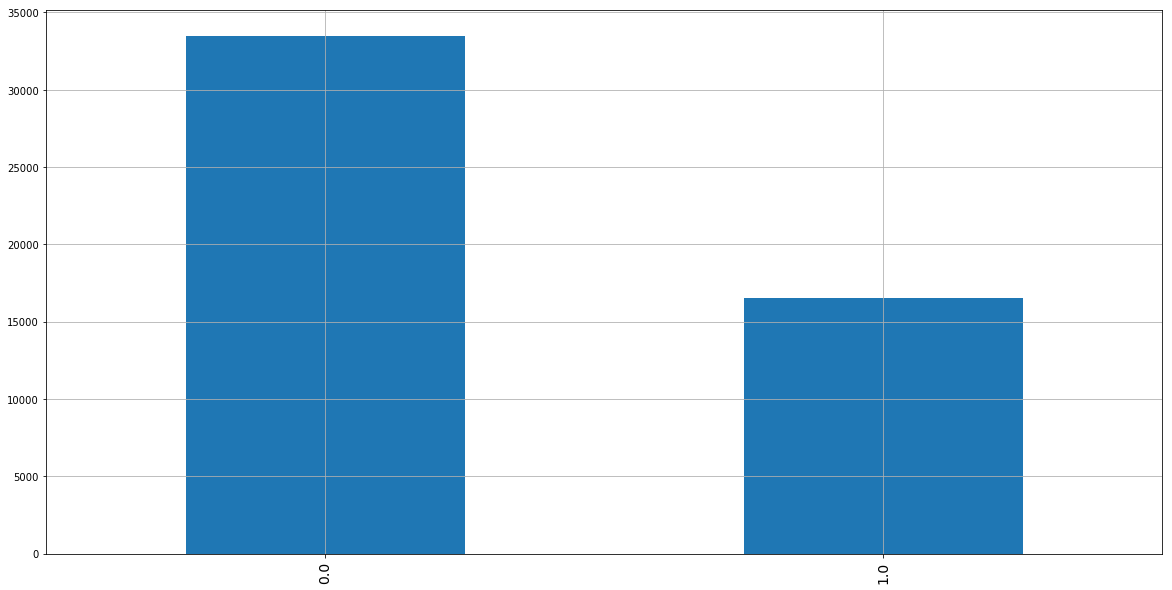

In [592]:
f = 'Var217'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],3)
# (csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

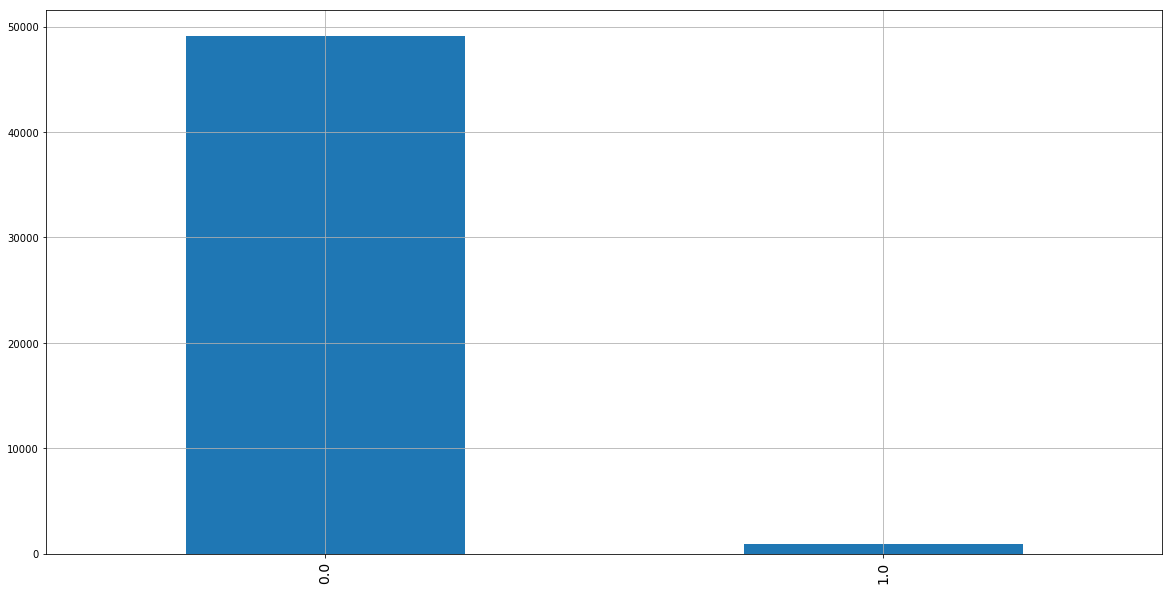

In [593]:
f = 'Var216'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],1)
# (csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

In [594]:
f = 'Var215'
delete(f)

In [595]:
f = 'Var214'
delete(f)

In [596]:
f = 'Var213'
delete(f)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


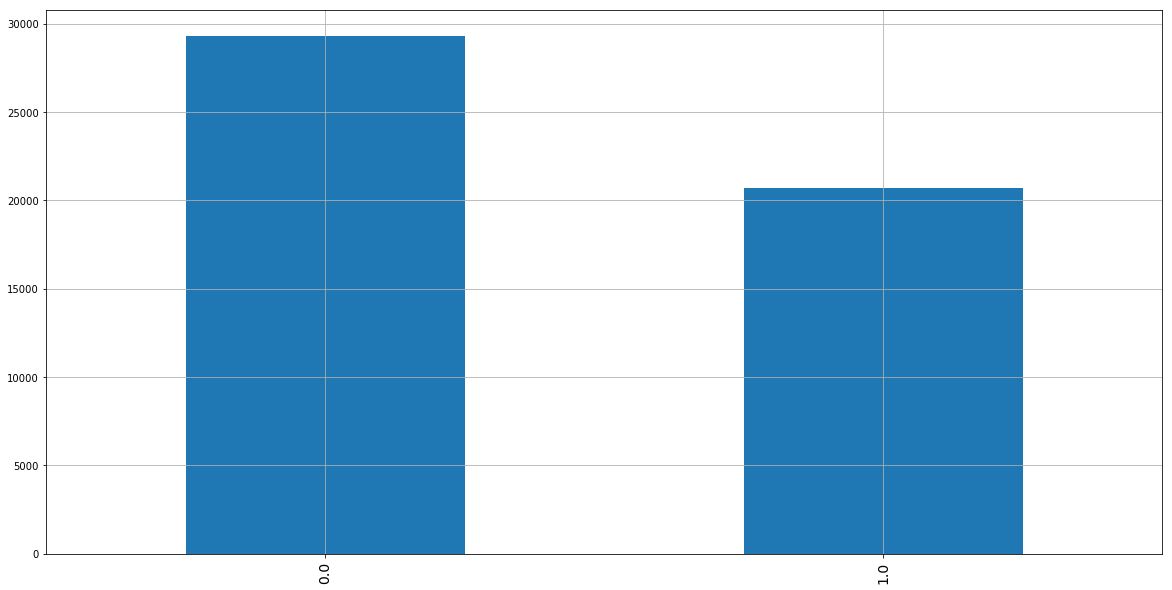

In [597]:
f = 'Var212'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=1]) = 2
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

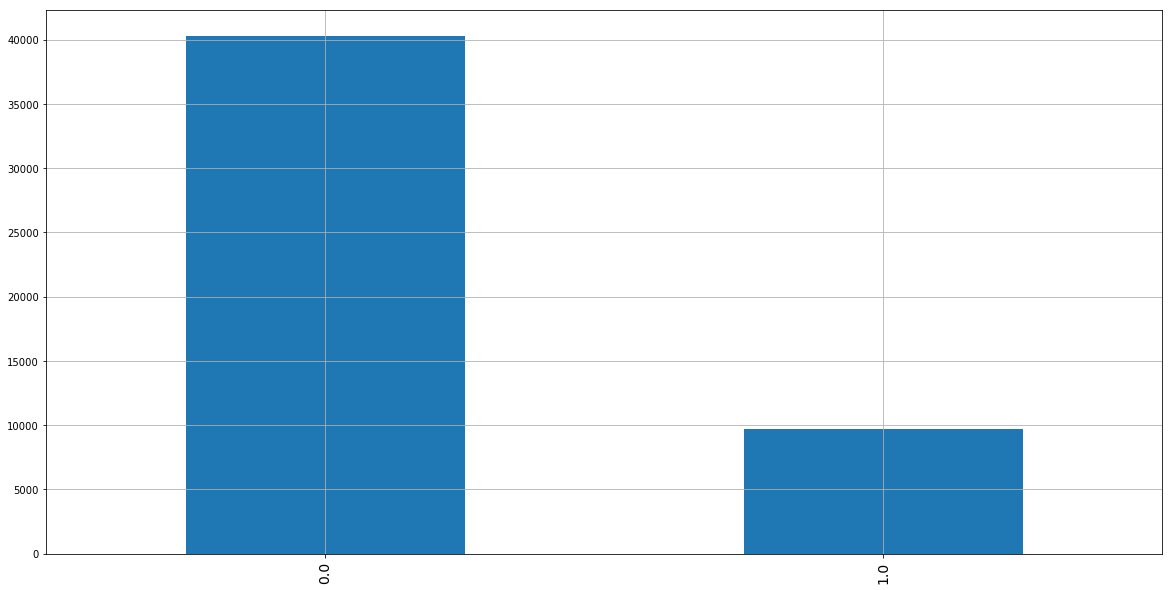

In [598]:
f = 'Var211'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
# (csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14)

In [599]:
f = 'Var210'
delete(f)

In [600]:
f = 'Var209'
delete(f)

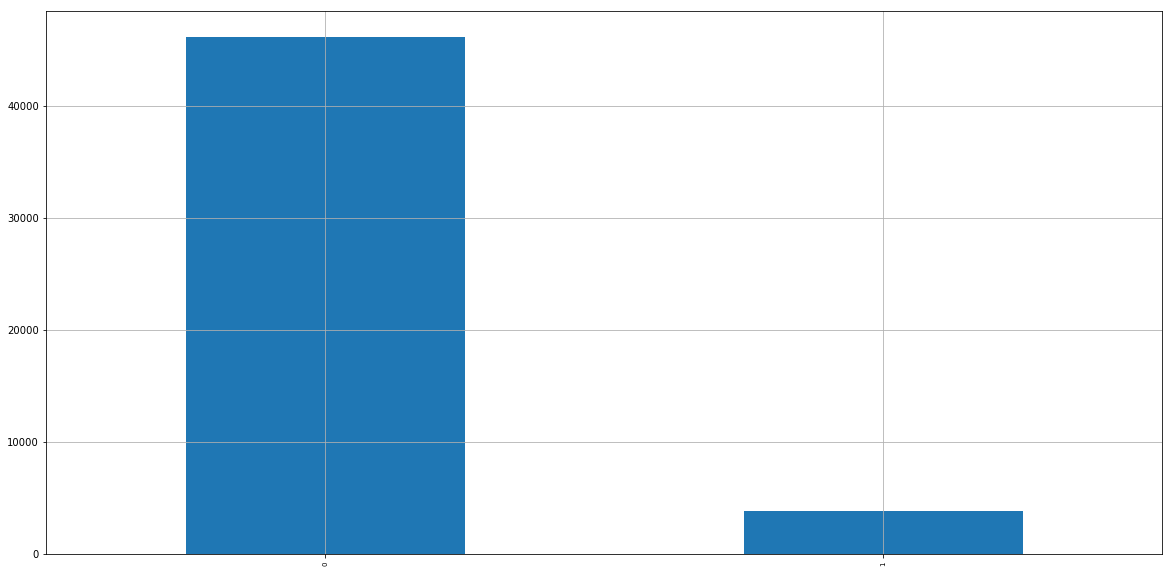

In [601]:
f = 'Var208'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],220,150,30)
plot(csv[f],sort=True,log=False)
csv[f] = standarize(csv[f])

In [602]:
f = 'Var207'
delete(f)

In [613]:
f = 'Var206'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1000)
(csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [614]:
f = 'Var205'
delete(f)

In [615]:
f = 'Var204'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],1500)
(csv[f][csv[f] == 1])=3
(csv[f][csv[f] == 11])=3
(csv[f][csv[f] !=3])=2

csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [616]:
f = 'Var203'
delete(f)

In [619]:
f = 'Var202'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10)
# plot(csv[f],sort=True,log=True)
csv[f] = standarize(csv[f])

In [620]:
f = 'Var201'
delete(f)

In [621]:
f = 'Var200'
delete(f)

In [622]:
f = 'Var199'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
print(len(csv[f][(csv[f]==0)]))
csv[f] = threshold_factorization(csv[f],200,100,1)
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=True)

370


4441


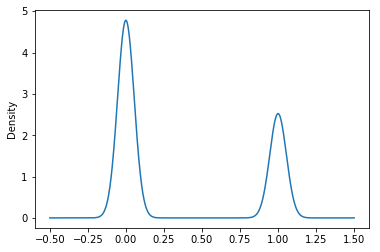

In [623]:
f = 'Var198'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
print(len(csv[f][(csv[f]==0)]))
csv[f] = threshold_factorization(csv[f],2800,1000,30)
csv[f] = standarize(csv[f])
csv[f].plot.kde()

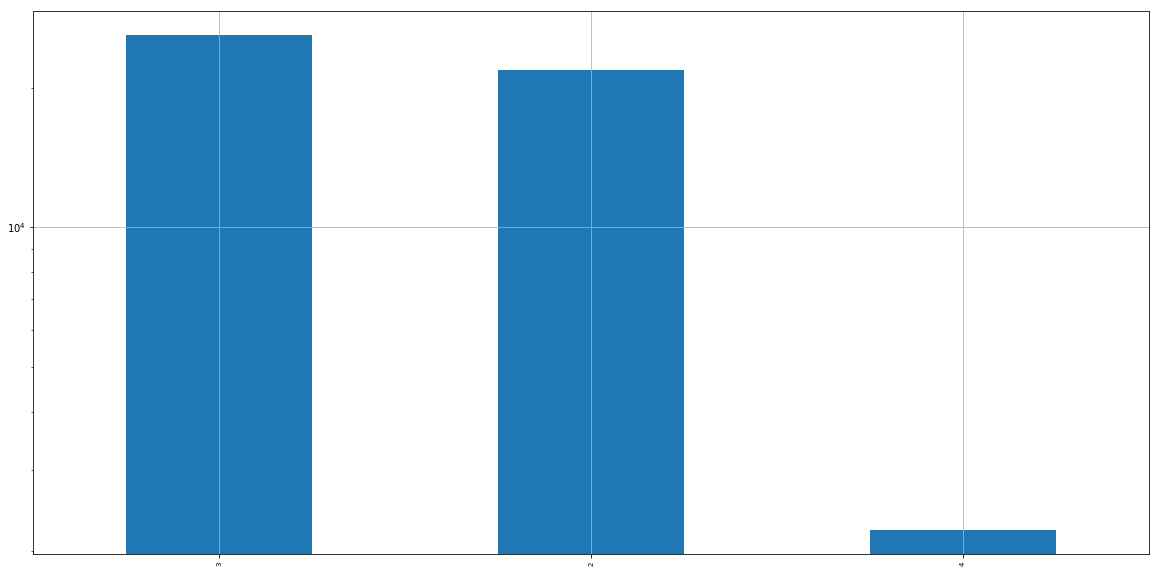

In [624]:
f = 'Var197'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000,1000,100)
plot(csv[f],sort=True,log=True)
csv[f] = standarize(csv[f])

In [630]:
f = 'Var196'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],220,150,30)
# plot(csv[f],sort=True,log=True)
csv[f] = standarize(csv[f])

In [631]:
f = 'Var195'
delete(f)

In [632]:
f = 'Var194'
delete(f)

In [633]:
f = 'Var193'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
# plot(csv[f],sort=True,log=False)
csv[f] = standarize(csv[f])

In [634]:
f = 'Var192'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],220,150,30)
# plot(csv[f],sort=True,log=False)
csv[f] = standarize(csv[f])

In [635]:
f = 'Var191'
delete(f)

In [636]:
f = 'Var190'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 74
val_type: <class 'numpy.float64'>
vals per class: 675.68
None


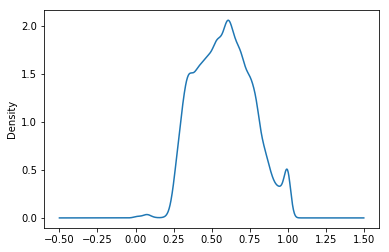

In [637]:
f = 'Var189'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 517
val_type: <class 'numpy.float64'>
vals per class: 96.71
None


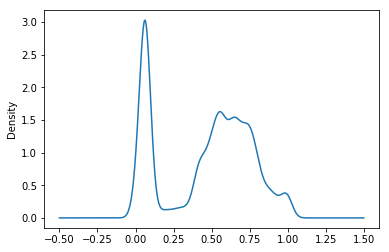

In [638]:
f = 'Var188'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 36
val_type: <class 'numpy.float64'>
vals per class: 1388.89
None


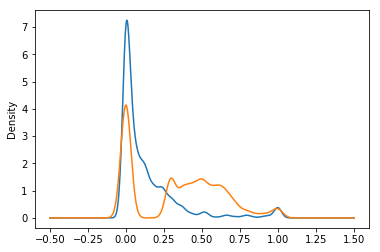

In [639]:
f = 'Var187'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


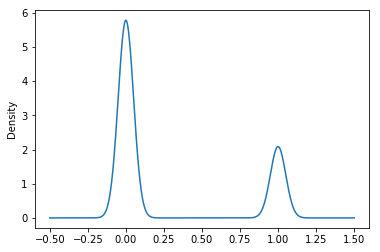

In [640]:
f = 'Var186'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [641]:
f = 'Var185'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 14
val_type: <class 'numpy.float64'>
vals per class: 3571.43
None


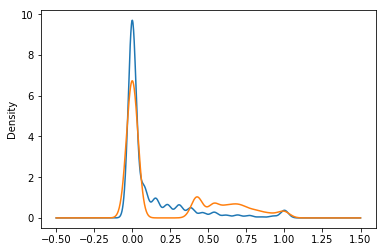

In [642]:
f = 'Var184'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 332
val_type: <class 'numpy.float64'>
vals per class: 150.6
None


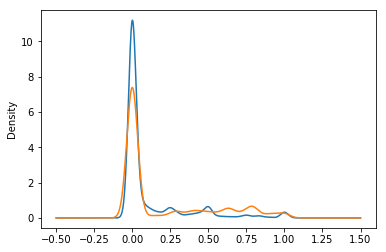

In [643]:
f = 'Var183'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 688
val_type: <class 'numpy.float64'>
vals per class: 72.67
None


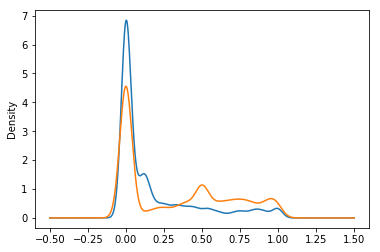

In [644]:
f = 'Var182'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [645]:
f = 'Var181'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 512
val_type: <class 'numpy.float64'>
vals per class: 97.66
None


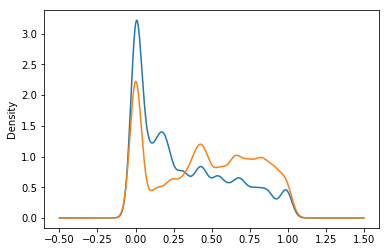

In [646]:
f = 'Var180'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


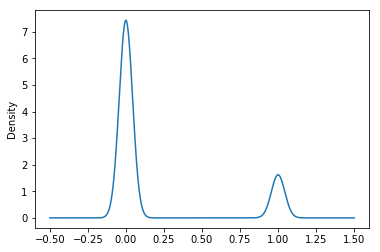

In [647]:
f = 'Var179'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 19
val_type: <class 'numpy.float64'>
vals per class: 2631.58
None


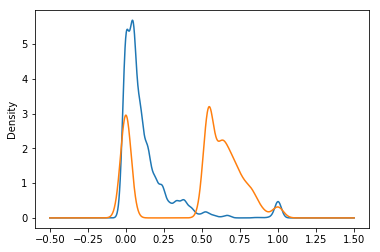

In [648]:
f = 'Var178'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/5))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


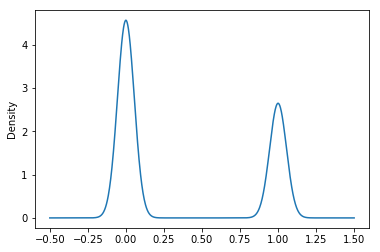

In [649]:
f = 'Var177'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


In [650]:
f = 'Var176'
delete(f)

In [651]:
f = 'Var175'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 12
val_type: <class 'numpy.float64'>
vals per class: 4166.67
None


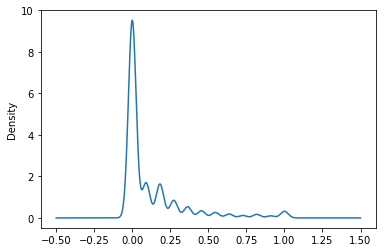

In [652]:
f = 'Var174'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


In [653]:
f = 'Var173'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 7
val_type: <class 'numpy.float64'>
vals per class: 7142.86
None


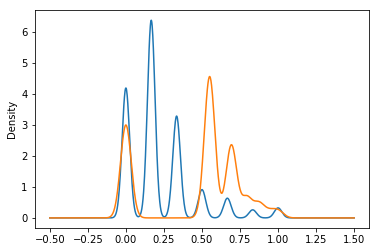

In [654]:
f = 'Var172'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 618
val_type: <class 'numpy.float64'>
vals per class: 80.91
None


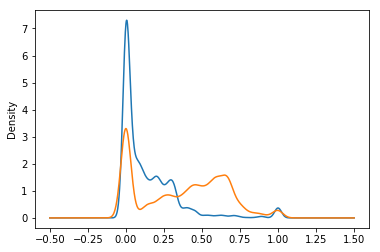

In [655]:
f = 'Var171'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


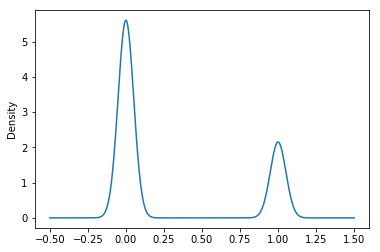

In [656]:
f = 'Var170'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


In [657]:
f = 'Var169'
delete(f)


min: 0.0
max: 1.0
nans: 0
unique: 441
val_type: <class 'numpy.float64'>
vals per class: 113.38
None


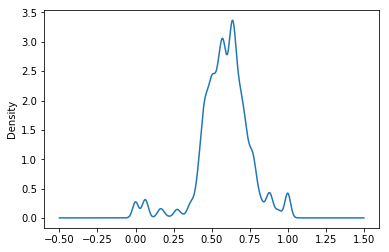

In [658]:
f = 'Var168'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


In [659]:
f = 'Var167'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


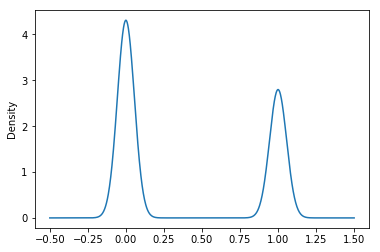

In [660]:
f = 'Var166'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


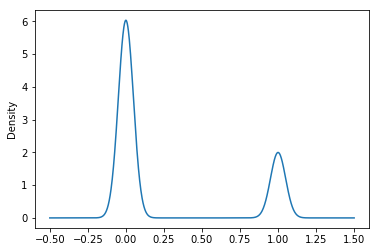

In [661]:
f = 'Var165'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


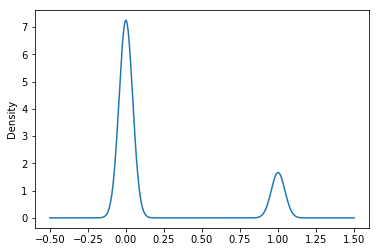

In [662]:
f = 'Var164'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 4692
val_type: <class 'numpy.float64'>
vals per class: 10.66
None


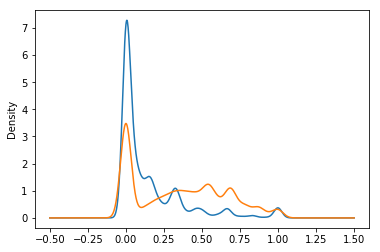

In [663]:
f = 'Var163'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()



min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


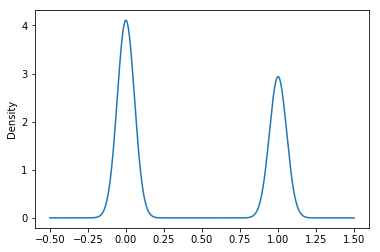

In [664]:
f = 'Var162'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


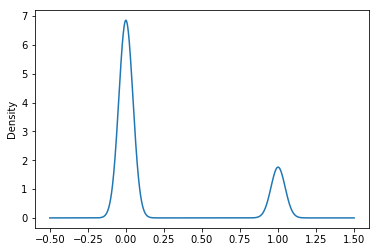

In [665]:
f = 'Var161'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 98
val_type: <class 'numpy.float64'>
vals per class: 510.2
None


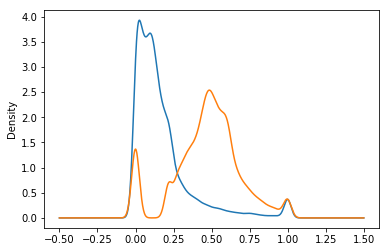

In [666]:
f = 'Var160'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


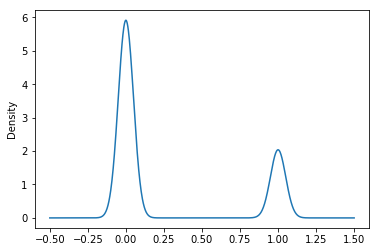

In [667]:
f = 'Var159'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


In [668]:
f = 'Var158'
delete(f)


min: 0.0
max: 1.0
nans: 0
unique: 45
val_type: <class 'numpy.float64'>
vals per class: 1111.11
None


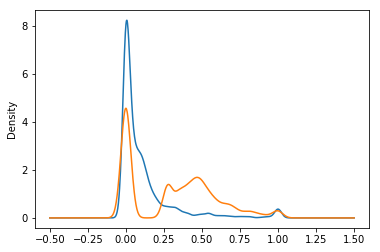

In [669]:
f = 'Var157'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 81
val_type: <class 'numpy.float64'>
vals per class: 617.28
None


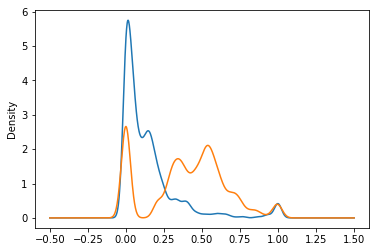

In [670]:
f = 'Var156'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


In [671]:
f = 'Var155'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 354
val_type: <class 'numpy.float64'>
vals per class: 141.24
None


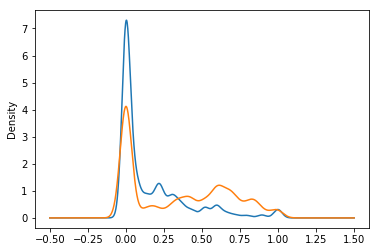

In [672]:
f = 'Var154'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 8582
val_type: <class 'numpy.float64'>
vals per class: 5.83
None


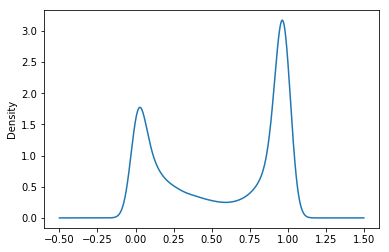

In [673]:
f = 'Var153'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 7
val_type: <class 'numpy.float64'>
vals per class: 7142.86
None


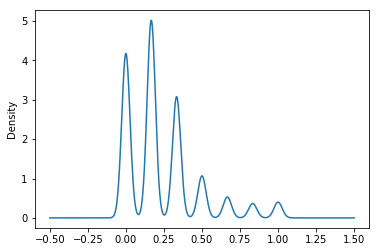

In [674]:
f = 'Var152'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 9
val_type: <class 'numpy.float64'>
vals per class: 5555.56
None


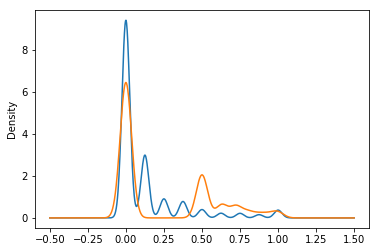

In [675]:
f = 'Var151'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 509
val_type: <class 'numpy.float64'>
vals per class: 98.23
None


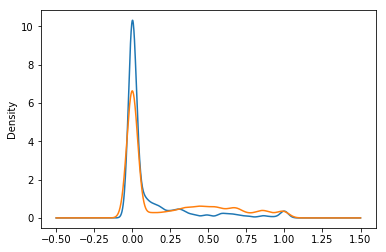

In [676]:
f = 'Var150'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 4685
val_type: <class 'numpy.float64'>
vals per class: 10.67
None


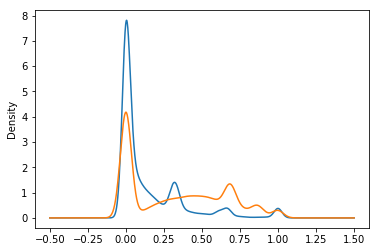

In [677]:
f = 'Var149'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 90
val_type: <class 'numpy.float64'>
vals per class: 555.56
None


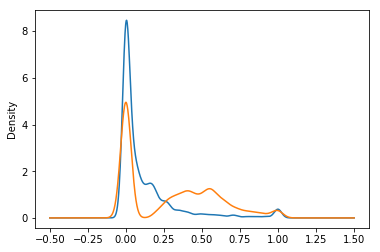

In [678]:
f = 'Var148'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 3
val_type: <class 'numpy.float64'>
vals per class: 16666.67
None


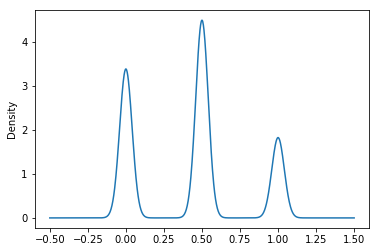

In [679]:
f = 'Var147'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [680]:
f = 'Var146'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 57
val_type: <class 'numpy.float64'>
vals per class: 877.19
None


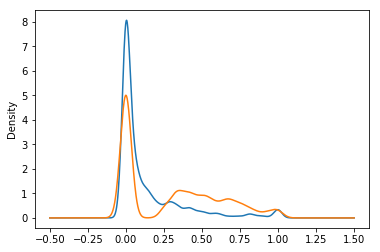

In [681]:
f = 'Var145'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 6
val_type: <class 'numpy.float64'>
vals per class: 8333.33
None


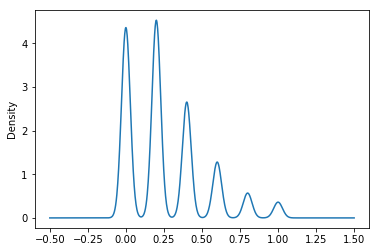

In [682]:
f = 'Var144'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [683]:
f = 'Var143'
delete(f)

In [684]:
f = 'Var142'
delete(f)

In [687]:
f = 'Var141'
delete(f)

In [691]:
f = 'Var140'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


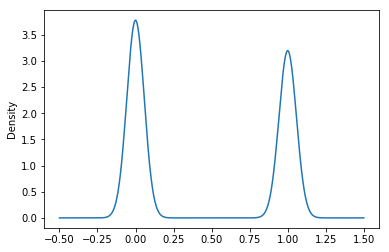

In [689]:
f = 'Var139'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [692]:
f = 'Var138'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


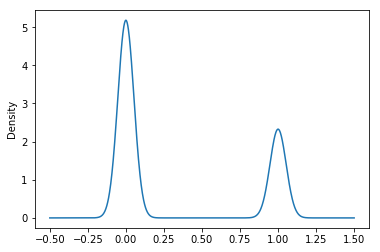

In [693]:
f = 'Var137'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [694]:
f = 'Var136'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 657
val_type: <class 'numpy.float64'>
vals per class: 76.1
None


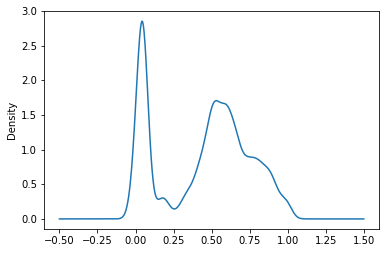

In [695]:
f = 'Var135'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 3702
val_type: <class 'numpy.float64'>
vals per class: 13.51
None


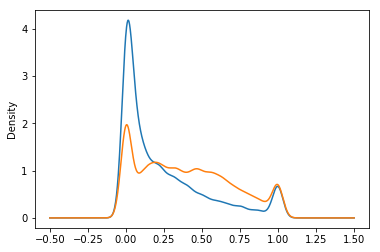

In [825]:
f = 'Var134'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 7036
val_type: <class 'numpy.float64'>
vals per class: 7.11
None


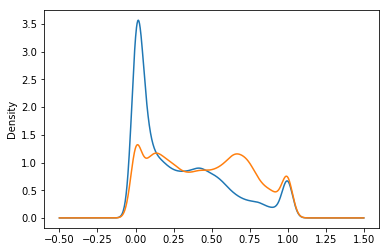

In [696]:
f = 'Var133'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


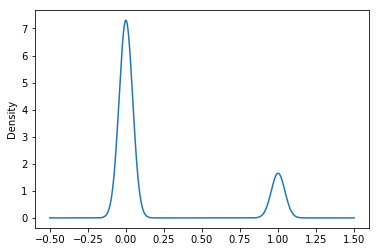

In [697]:
f = 'Var132'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


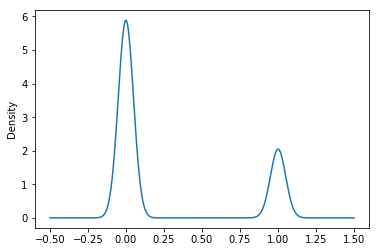

In [698]:
f = 'Var131'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [699]:
f = 'Var130'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 12
val_type: <class 'numpy.float64'>
vals per class: 4166.67
None


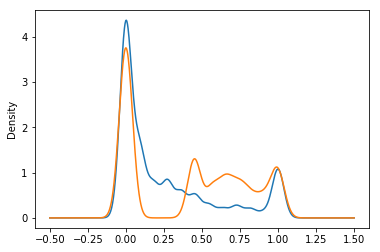

In [700]:
f = 'Var129'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 51
val_type: <class 'numpy.float64'>
vals per class: 980.39
None


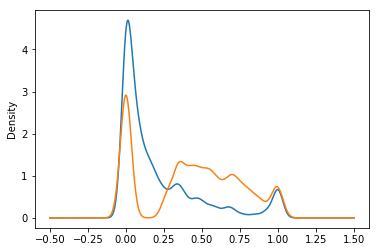

In [701]:
f = 'Var128'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


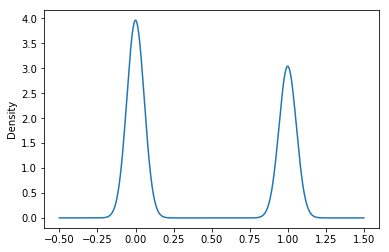

In [702]:
f = 'Var127'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 37
val_type: <class 'numpy.float64'>
vals per class: 1351.35
None


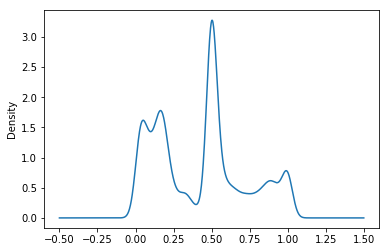

In [703]:
f = 'Var126'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 5096
val_type: <class 'numpy.float64'>
vals per class: 9.81
None


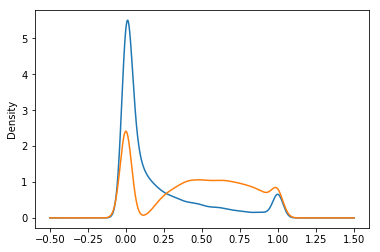

In [704]:
f = 'Var125'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/4))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


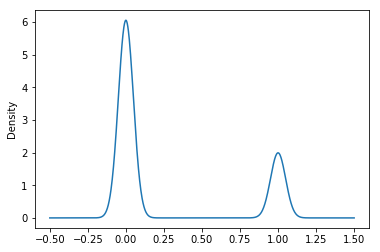

In [705]:
f = 'Var124'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 24
val_type: <class 'numpy.float64'>
vals per class: 2083.33
None


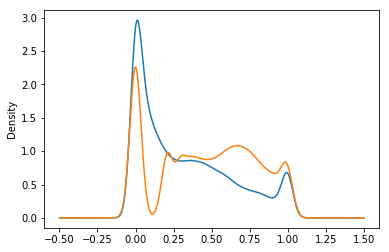

In [706]:
f = 'Var123'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [707]:
f = 'Var122'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


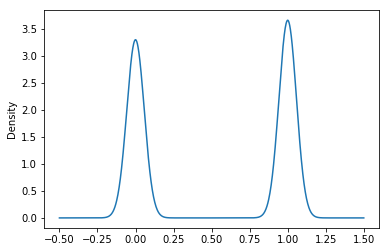

In [708]:
f = 'Var121'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


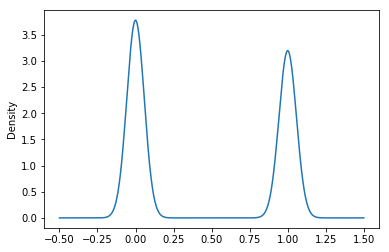

In [709]:
f = 'Var120'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 477
val_type: <class 'numpy.float64'>
vals per class: 104.82
None


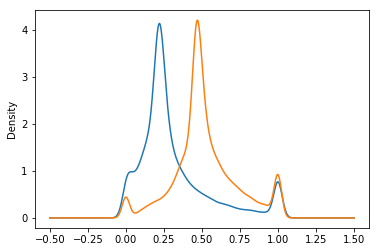

In [710]:
f = 'Var119'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [711]:
f = 'Var118'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


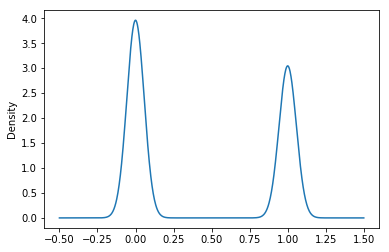

In [712]:
f = 'Var117'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

In [713]:
f = 'Var116'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 14
val_type: <class 'numpy.float64'>
vals per class: 3571.43
None


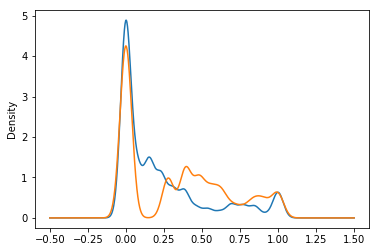

In [714]:
f = 'Var115'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 548
val_type: <class 'numpy.float64'>
vals per class: 91.24
None


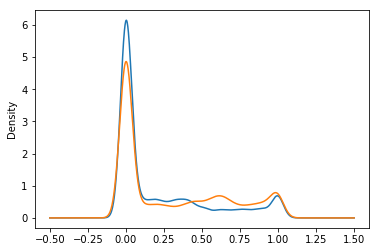

In [715]:
f = 'Var114'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [716]:
f = 'Var113'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 27
val_type: <class 'numpy.float64'>
vals per class: 1851.85
None


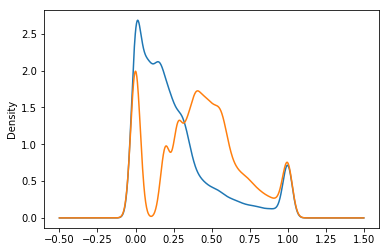

In [717]:
f = 'Var112'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 672
val_type: <class 'numpy.float64'>
vals per class: 74.4
None


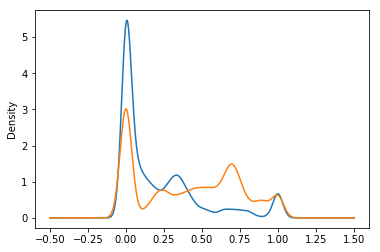

In [718]:
f = 'Var111'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


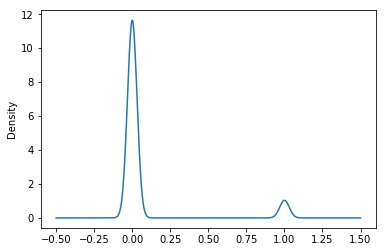

In [719]:
f = 'Var110'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 22
val_type: <class 'numpy.float64'>
vals per class: 2272.73
None


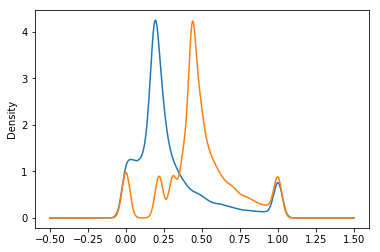

In [720]:
f = 'Var109'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [722]:
f = 'Var108'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


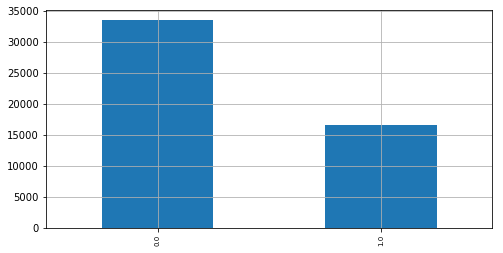

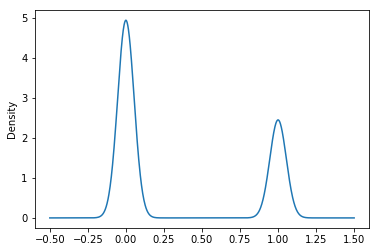

In [723]:
f = 'Var107'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()


In [724]:
f = 'Var106'
delete(f)

In [725]:
f = 'Var105'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


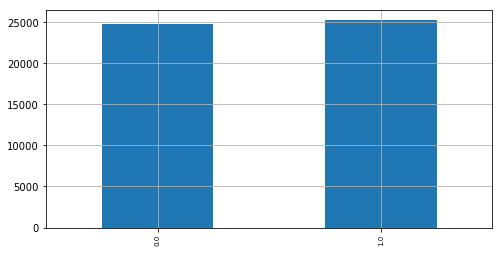

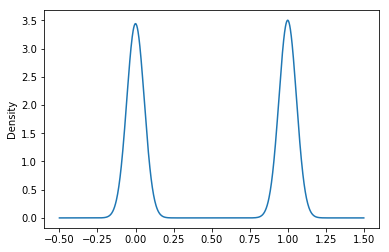

In [726]:
f = 'Var104'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],2100)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()


min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


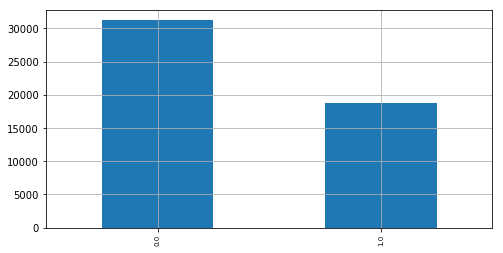

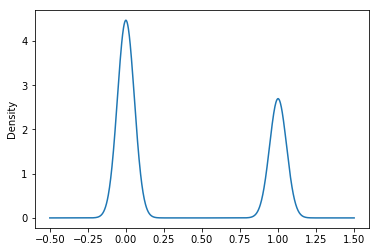

In [727]:
f = 'Var103'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()


In [829]:
f = 'Var101'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


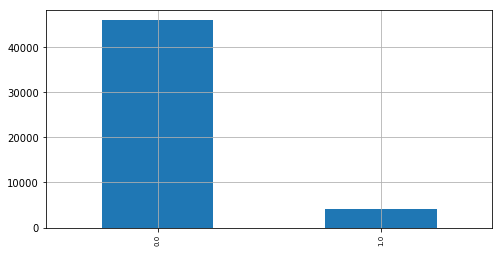

In [826]:
f = 'Var100'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10)
plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 30
val_type: <class 'numpy.float64'>
vals per class: 1666.67
None


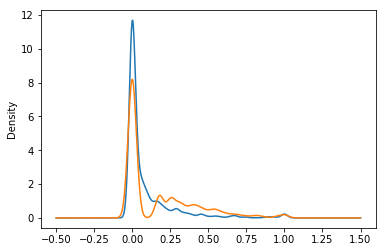

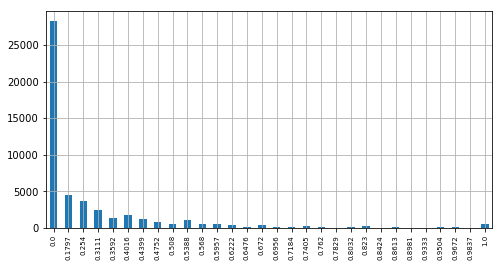

In [730]:
f = 'Var99'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()
plot(csv[f].sort_values(),log=False,small=True)

min: 0.0
max: 1.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


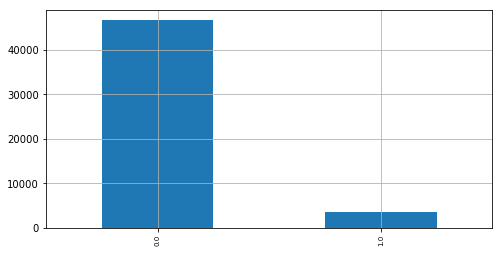

In [731]:
f = 'Var98'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()

min: 1.0
max: 2.0
nans: 0
unique: 2
val_type: <class 'numpy.float64'>
vals per class: 25000.0
None


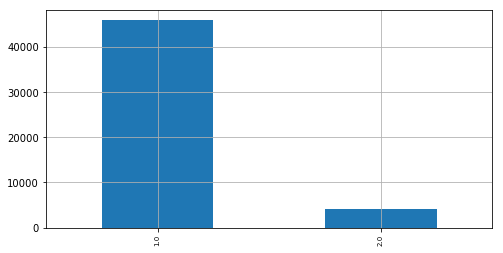

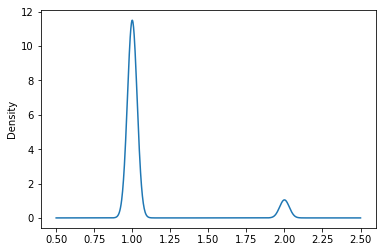

In [732]:
f = 'Var97'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()

In [733]:
f = 'Var95'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 4435
val_type: <class 'numpy.float64'>
vals per class: 11.27
None


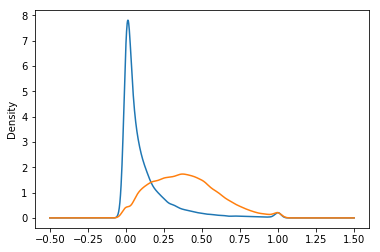

In [734]:
f = 'Var94'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
# plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [735]:
f = 'Var93'
delete(f)

min: 0.0
max: 1.0
nans: 0
unique: 107
val_type: <class 'numpy.float64'>
vals per class: 467.29
None


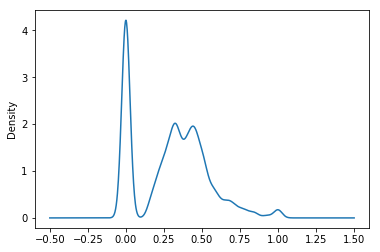

In [736]:
f = 'Var91'
print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

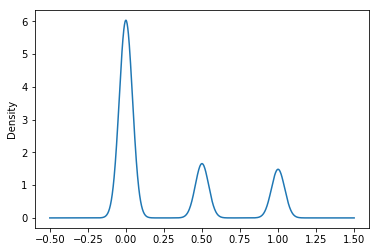

In [737]:
f = 'Var89'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)
csv[f].plot.kde()

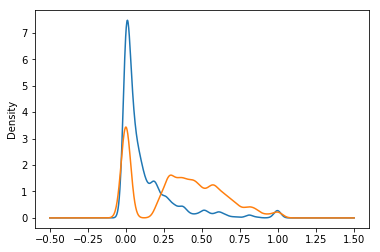

In [738]:
f = 'Var88'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

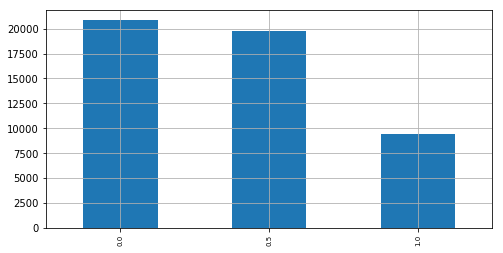

In [739]:
f = 'Var87'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

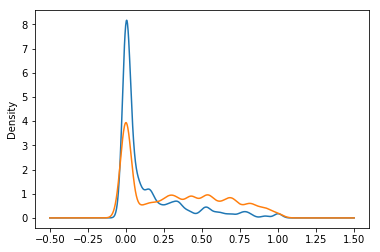

In [740]:
f = 'Var86'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

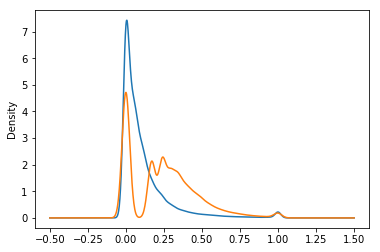

In [741]:
f = 'Var85'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

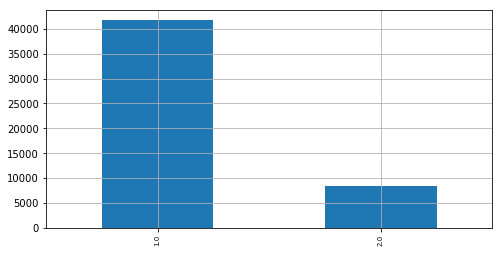

In [742]:
f = 'Var84'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],20000)
plot(csv[f].sort_values(),log=False,small=True)


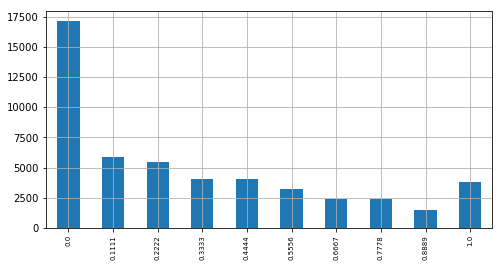

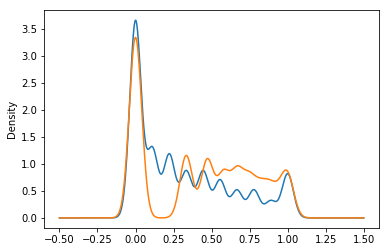

In [743]:
f = 'Var83'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.93))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],2)
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

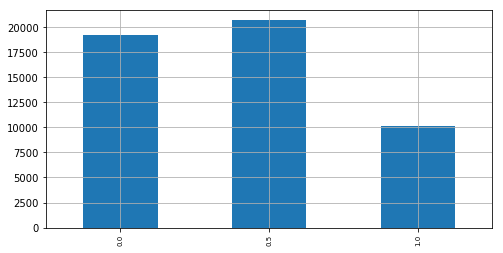

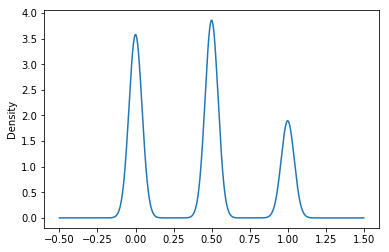

In [744]:
f = 'Var82'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],2)
plot(csv[f].sort_values(),log=False,small=True)
csv[f].plot.kde()

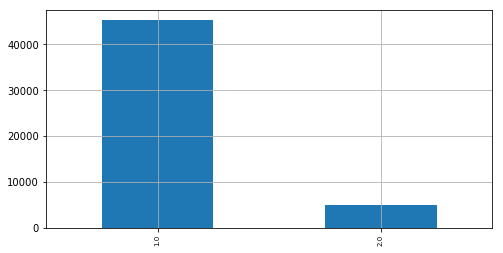

In [745]:
f = 'Var81'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],2)
plot(csv[f].sort_values(),log=False,small=True)
one_hot_encoding(f)

In [748]:
f = 'Var80'
delete(f)

min: 0.0
max: 666.0
nans: 49298
unique: 24
val_type: <class 'numpy.float64'>
vals per class: 29.25
None


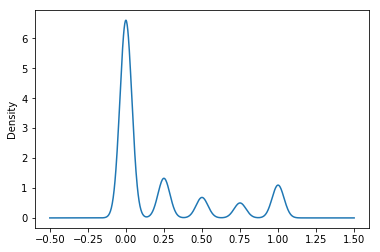

In [749]:
f = 'Var77'
print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
csv[f].plot.kde()

min: 0.0
max: 1.0
nans: 0
unique: 5
val_type: <class 'numpy.float64'>
vals per class: 10000.0
None


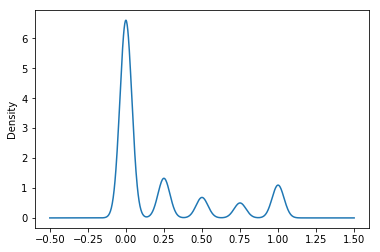

In [750]:
f = 'Var77'
print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
csv[f].plot.kde()

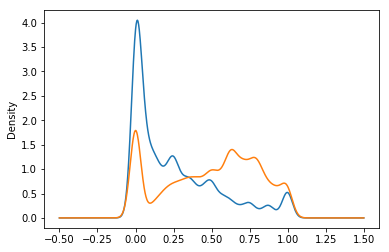

In [751]:
f = 'Var76'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.97))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

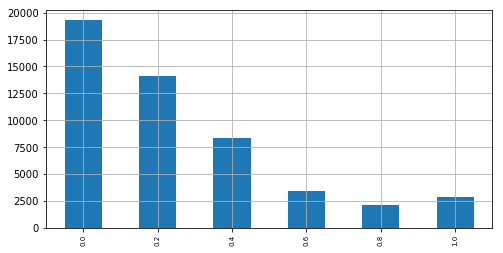

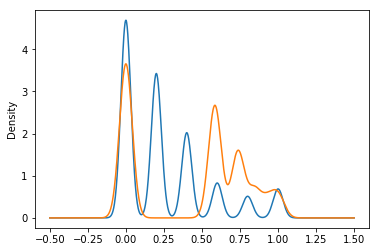

In [752]:
f = 'Var75'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

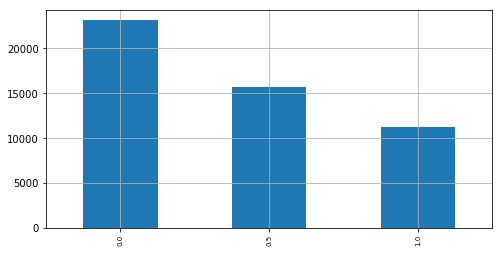

In [753]:
f = 'Var74'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.7))
csv[f] = threshold_factorization(csv[f],20000,10000)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)


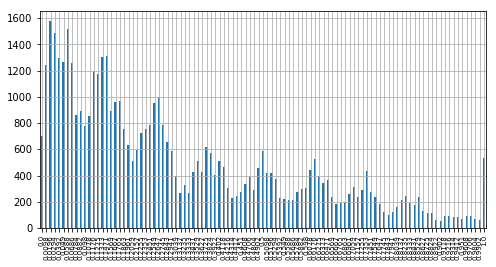

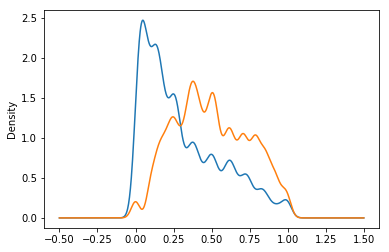

In [754]:
f = 'Var73'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

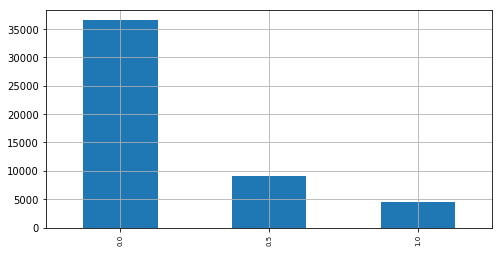

In [755]:
f = 'Var72'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

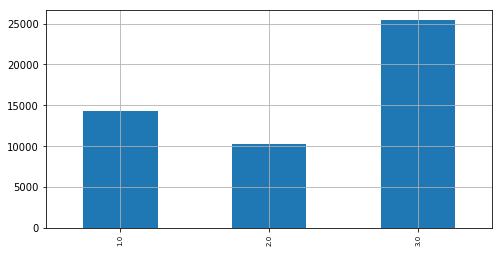

In [756]:
f = 'Var71'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.80))
csv[f] = threshold_factorization(csv[f],12000,8000)
plot(csv[f].sort_values(),log=False,small=True)

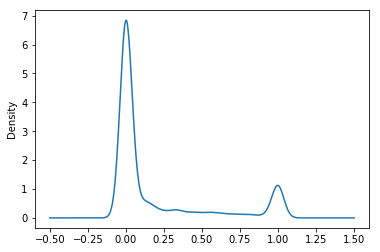

In [757]:
f = 'Var70'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
csv[f].plot.kde()

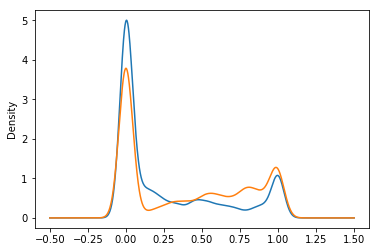

In [758]:
f = 'Var69'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

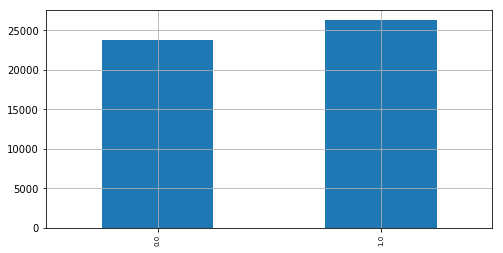

In [759]:
f = 'Var68'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)

In [760]:
f = 'Var67'
delete(f)

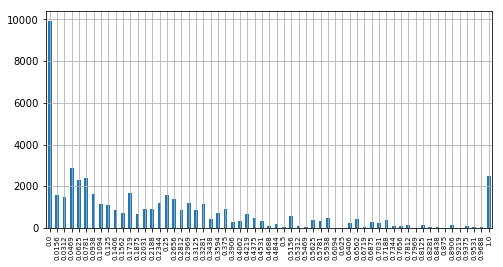

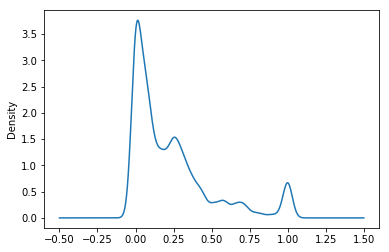

In [761]:
f = 'Var66'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
csv[f].plot.kde()

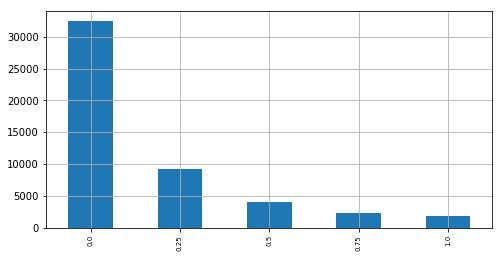

In [762]:
f = 'Var65'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)

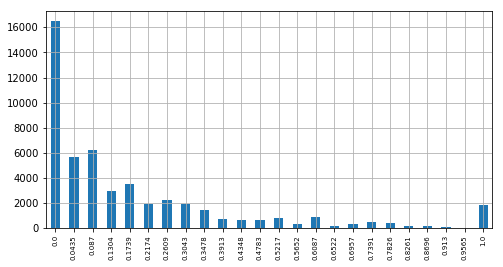

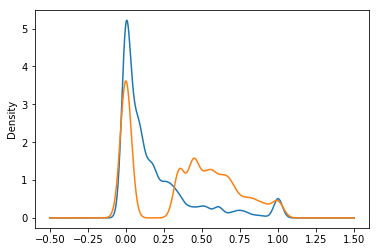

In [763]:
f = 'Var63'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.97))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

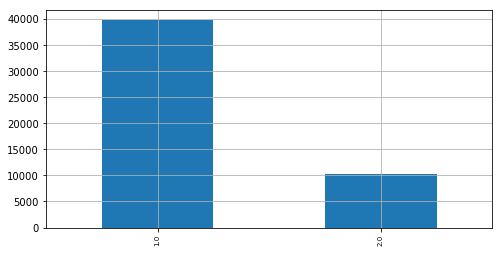

In [764]:
f = 'Var62'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],20000)
plot(csv[f].sort_values(),log=False,small=True)

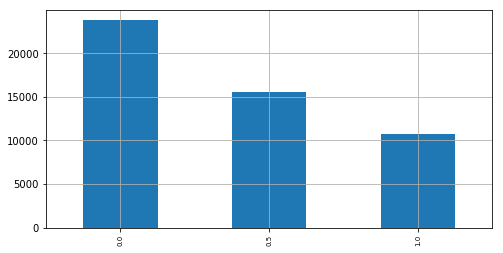

In [765]:
f = 'Var61'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],8000,2000)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),log=False,small=True)

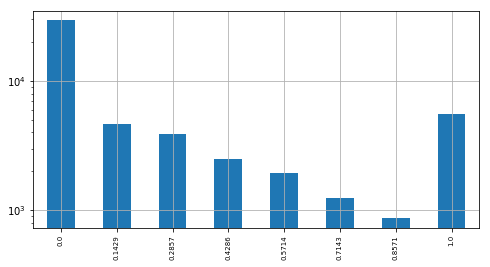

In [766]:
f = 'Var60'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

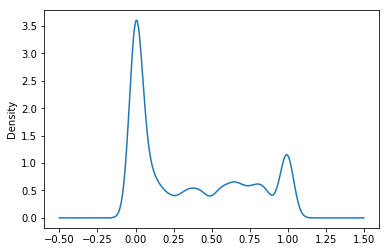

In [767]:
f = 'Var59'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

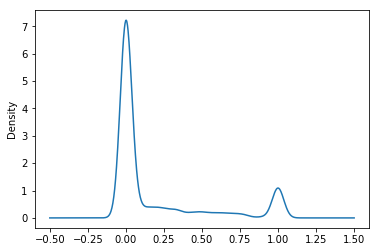

In [768]:
f = 'Var58'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)
csv[f].plot.kde()

In [769]:
f = 'Var57'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f],small=True)

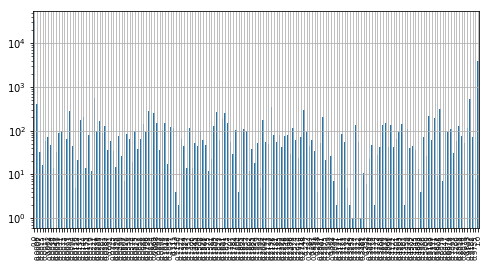

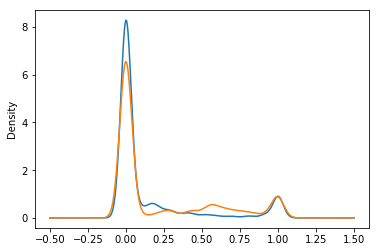

In [770]:
f = 'Var56'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.93))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

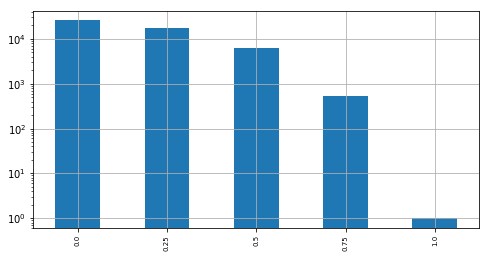

In [771]:
f = 'Var54'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

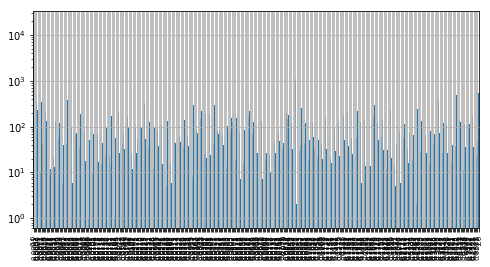

In [772]:
f = 'Var53'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

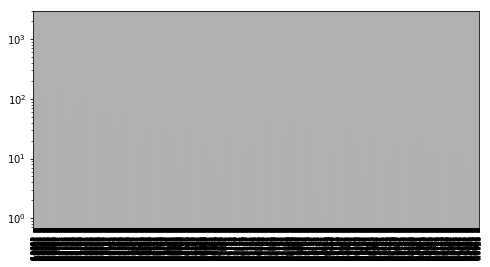

In [773]:
f = 'Var51'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

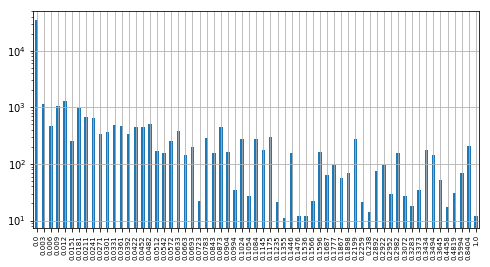

In [774]:
f = 'Var50'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

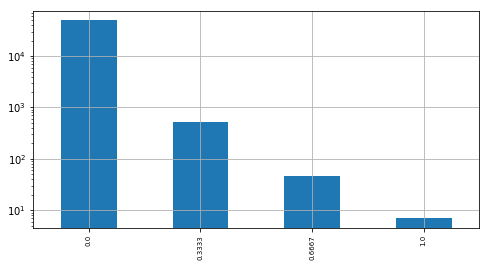

In [775]:
f = 'Var49'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

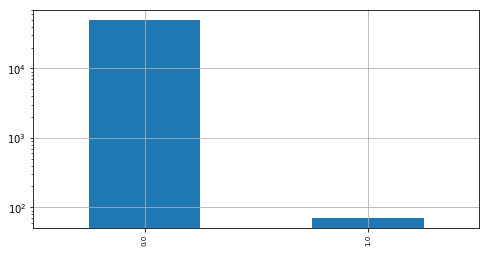

In [776]:
f = 'Var47'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

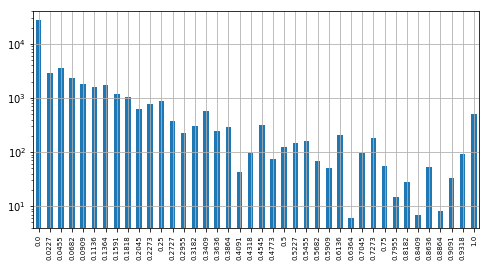

In [777]:
f = 'Var46'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

In [778]:
f = 'Var44'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

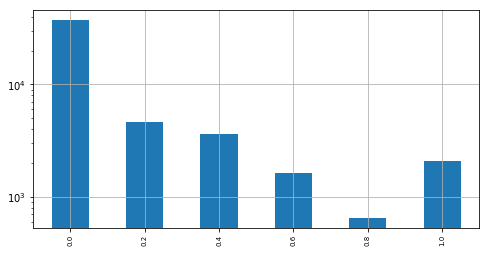

In [779]:
f = 'Var43'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

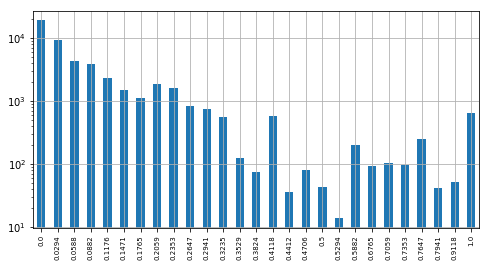

In [780]:
f = 'Var41'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

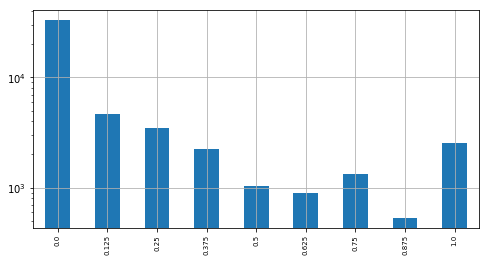

In [781]:
f = 'Var40'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

In [782]:
f = 'Var38'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

min: 0.0
max: 11635020.0
nans: 48421
unique: 551
val_type: <class 'numpy.float64'>
vals per class: 2.87


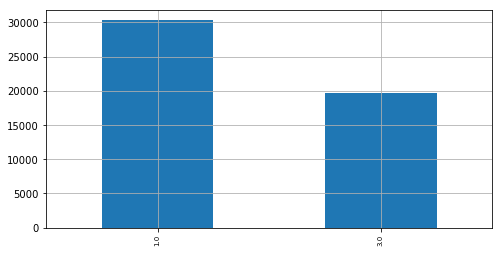

In [783]:
f = 'Var37'
csv[f] = csv_org[f]
stat(f)
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],9000,6000)
plot(csv[f].sort_values(),log=False,small=True)
one_hot_encoding(f)

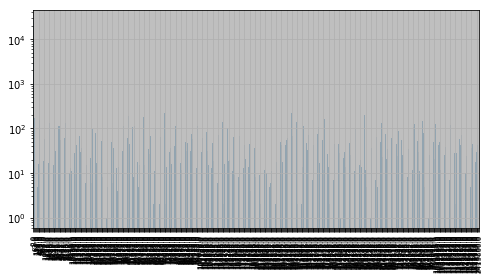

In [784]:
f = 'Var36'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = threshold_factorization(csv[f],20,3,1)
plot(csv[f].sort_values(),small=True)
one_hot_encoding(f)

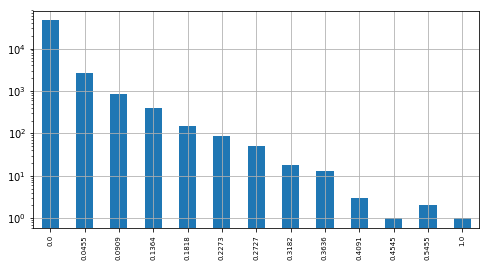

In [785]:
f = 'Var35'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

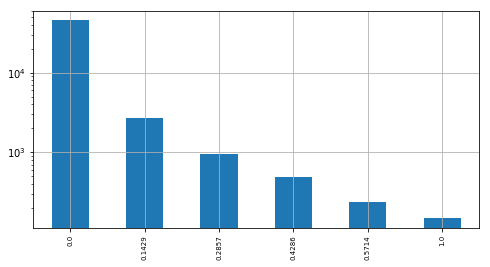

In [786]:
f = 'Var34'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

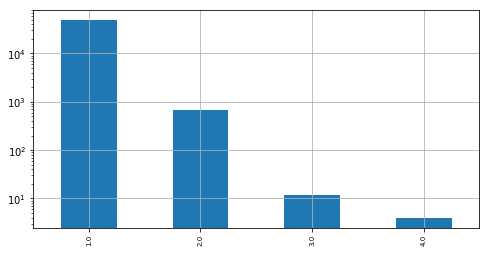

In [787]:
f = 'Var33'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],20,3,1)
plot(csv[f].sort_values(),small=True)
one_hot_encoding(f)

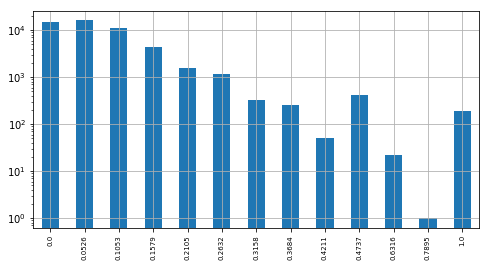

In [788]:
f = 'Var30'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

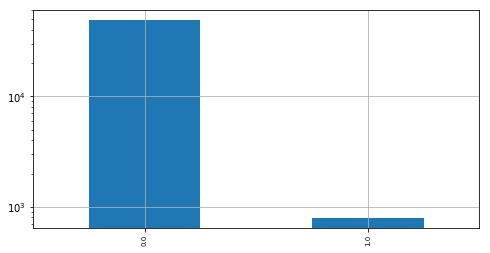

In [789]:
f = 'Var29'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

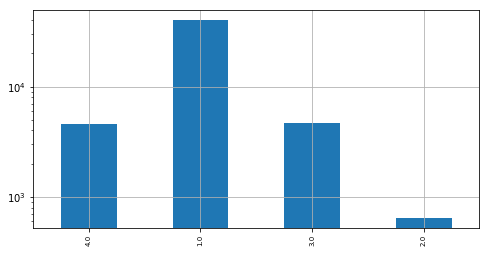

In [790]:
f = 'Var28'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],9,8,3)
plot(csv[f],small=True)
one_hot_encoding(f)

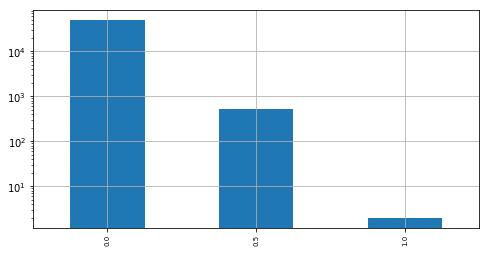

In [791]:
f = 'Var27'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)


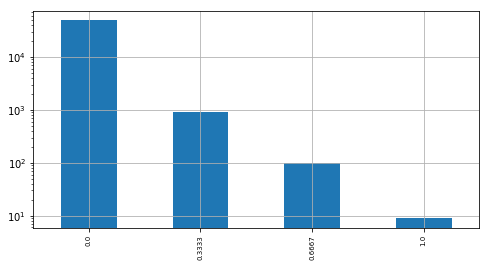

In [792]:
f = 'Var26'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)


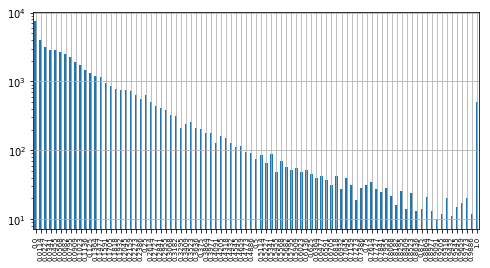

In [793]:
f = 'Var25'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)


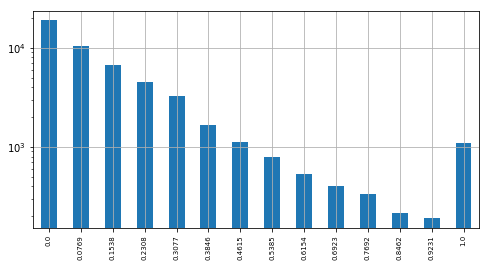

In [794]:
f = 'Var24'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

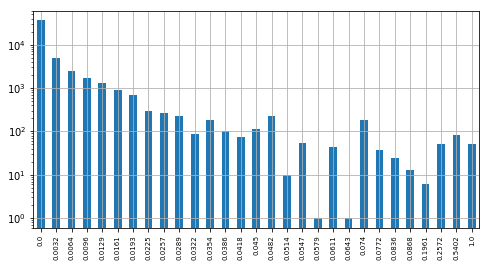

In [795]:
f = 'Var23'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

In [796]:
f = 'Var22'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

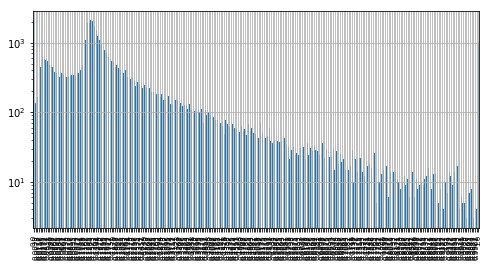

In [797]:
f = 'Var21'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

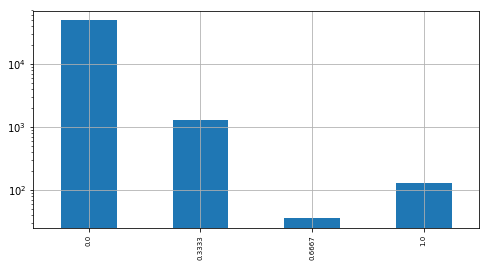

In [798]:
f = 'Var19'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

min: 0.0
max: 948.0
nans: 0
unique: 26
val_type: <class 'numpy.float64'>
vals per class: 1923.08


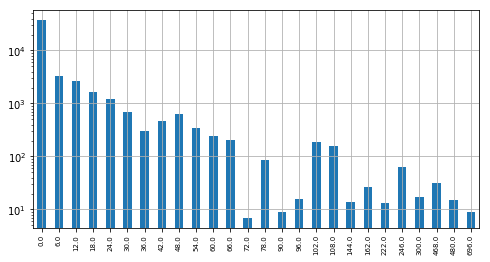

In [799]:
f = 'Var18'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
stat(f)
csv[f] = cast(csv[f],-100,696)
plot(csv[f].sort_values(),small=True)

min: 0.0
max: 1220.0
nans: 0
unique: 37
val_type: <class 'numpy.float64'>
vals per class: 1351.35


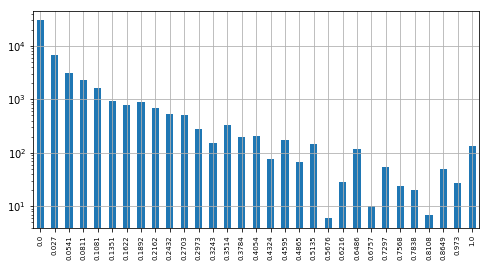

In [800]:
f = 'Var17'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
stat(f)
csv[f] = cast(csv[f],-100,185)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

min: 0.0
max: 434.92
nans: 0
unique: 597
val_type: <class 'numpy.float64'>
vals per class: 83.75


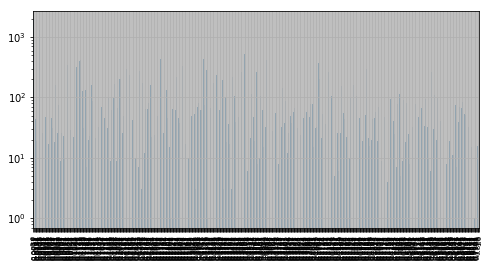

In [801]:
f = 'Var16'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
stat(f)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

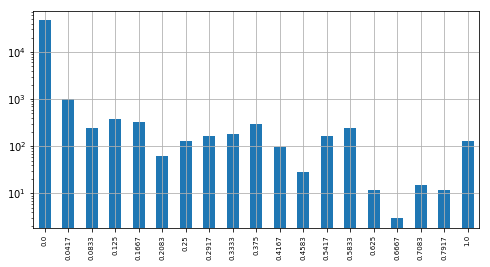

In [802]:
f = 'Var14'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)
one_hot_encoding(f)

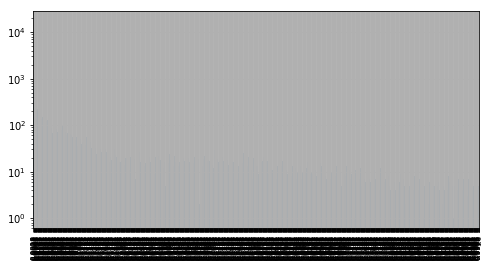

In [803]:
f = 'Var13'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,5000)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

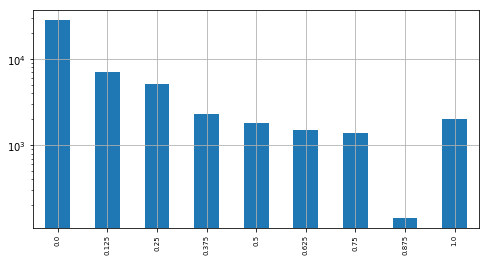

In [804]:
f = 'Var12'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

min: 8.0
max: 40.0
nans: 48760
unique: 6
val_type: <class 'numpy.float64'>
vals per class: 206.67


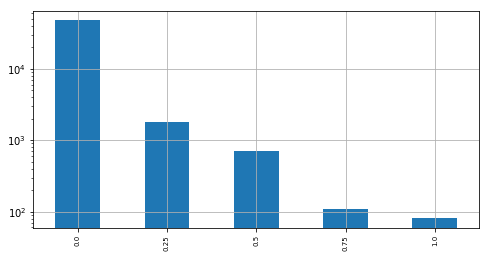

In [805]:
f = 'Var11'
stat(f)
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

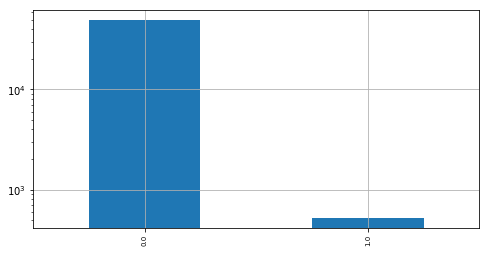

In [806]:
f = 'Var10'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].median())
csv[f] = threshold_factorization(csv[f],1)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

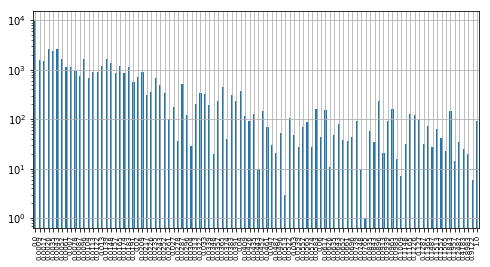

In [807]:
f = 'Var9'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].median())
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

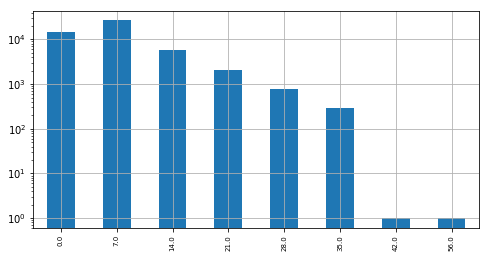

In [808]:
f = 'Var7'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,56)
# csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

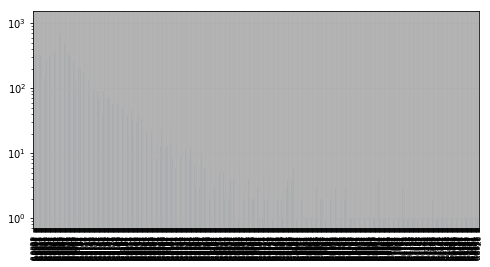

In [809]:
f = 'Var6'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

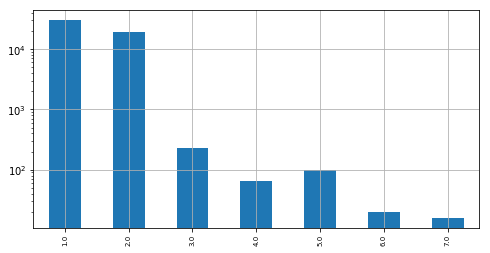

In [810]:
f = 'Var5'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,7,5,4,2,1)
plot(csv[f].sort_values(),small=True)
binary_encoding(f)

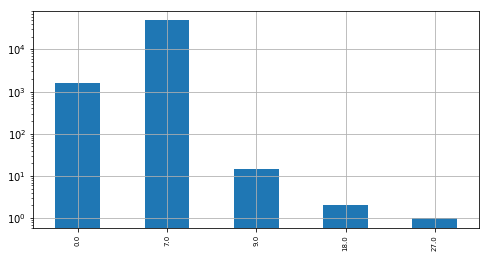

In [811]:
f = 'Var4'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(7)
# csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)

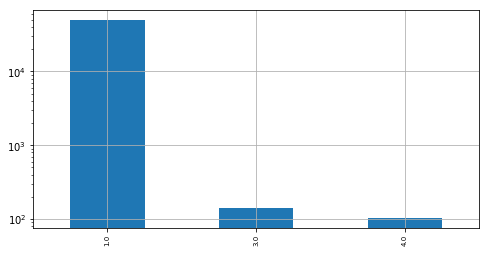

In [812]:
f = 'Var3'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,100,1)
plot(csv[f].sort_values(),sort=True,small=True)
one_hot_encoding(f)

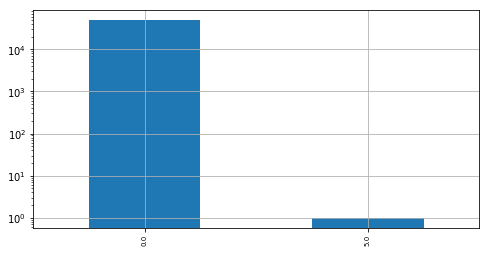

In [813]:
f = 'Var2'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
plot(csv[f].sort_values(),small=True)
one_hot_encoding(f)

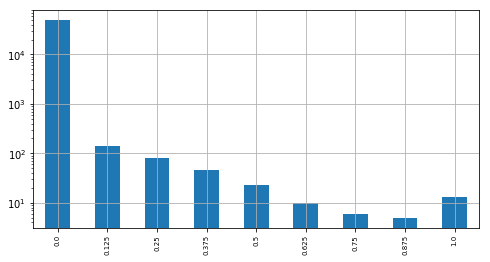

In [814]:
f = 'Var1'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
plot(csv[f].sort_values(),small=True)